# MSAEXP spectroscopic pipeline 2025

With extended wavelength ranges

In [38]:
import time
time.ctime()

'Thu Jun 26 22:52:17 2025'

In [1]:
# Are we on a GitHub codespace?
import os

if os.getcwd().startswith("/workspaces/msaexp"):
    import os

    os.environ["CRDS_PATH"] = os.path.join("/tmp/", "crds_cache")

    if not os.path.exists(os.environ["CRDS_PATH"]):
        ! mkdir {os.environ['CRDS_PATH']}

    os.environ["CRDS_SERVER_URL"] = "https://jwst-crds.stsci.edu"

    print(
        "On codespace: ",
        os.environ["CRDS_PATH"],
        os.environ["CRDS_SERVER_URL"],
    )

    workdir = "/workspaces/msaexp/docs/examples/codespace"
    if not os.path.exists(workdir):
        ! mkdir {workdir}

    os.chdir(workdir)
else:
    print("(not on a codespace)")

# CRDS variables
import os

if "CRDS_PATH" not in os.environ is None:
    os.environ["CRDS_PATH"] = f"{os.getcwd()}/crds_cache"

    if not os.path.exists(os.environ["CRDS_PATH"]):
        os.makedirs(os.environ["CRDS_PATH"])

    os.environ["CRDS_SERVER_URL"] = "https://jwst-crds.stsci.edu"

try:
    import numba
except ImportError:
    ! pip install numba

if os.path.exists("msaexp-demo-2025"):
    os.chdir("msaexp-demo-2025")

os.getcwd()

(not on a codespace)


'/usr/local/share/python/msaexp/docs/examples/msaexp-demo-2025'

In [2]:
import os
import glob
import yaml
import warnings
import time

import numpy as np
import matplotlib.pyplot as plt

import grizli
from grizli import utils, jwst_utils

jwst_utils.set_quiet_logging()
utils.set_warnings()

import astropy.io.fits as pyfits
import jwst.datamodels
import jwst

import mastquery.jwst

import msaexp
from msaexp import pipeline
import msaexp.utils as msautils
import msaexp.slit_combine

msautils.SFLAT_STRAIGHTEN = 3

print(f"jwst version = {jwst.__version__}")
print(f"grizli version = {grizli.__version__}")
print(f"msaexp version = {msaexp.__version__}")

plt.rcParams["scatter.marker"] = "."
plt.rcParams["image.origin"] = "lower"
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["grid.linestyle"] = ":"

jwst version = 1.16.1
grizli version = 1.12.15.dev13+ge6e5481.d20250624
msaexp version = 0.9.8.dev24+g90648f3.d20250626


# Query MAST for NIRSpec data

Query by program name and download `rate.fits` files with `mastquery`.  May need to set `$MAST_TOKEN` environment variable to download proprietary datasets from MAST.

Can optionally limit the query to specific 

 - gratings:  ``prism``, ``g140m``, ``g235m``, ``g395m``, ``g140m``, ``g235m``, ``g395m``
 - filters:  ``clear``, ``f170lp``, ``f100lp``, ``f170lp``, ``f290lp``
 - detectors: ``nrs1``, ``nrs2``
 
 

In [3]:
## Optional
# Find the program, source_id based on a particular position
ra, dec = 214.97433534766, 52.92461350726

slits_url = (
    f"https://grizli-cutout.herokuapp.com/nirspec_slits?coord={ra},{dec}"
)
slits = utils.read_catalog(slits_url, format="csv")

slits["program", "msametfl", "source_id", "grating", "footprint"][
    slits["is_source"] == "True"
]

<GTable length=21>
program ...
 int64  ...
------- ...
   1345 ...
   1345 ...
   1345 ...
   1345 ...
   1345 ...
   1345 ...
   1345 ...
   1345 ...
   1345 ...
   1345 ...
   1345 ...
   1345 ...
   1345 ...
   1345 ...
   1345 ...
   4233 ...
   4233 ...
   4233 ...
   4233 ...
   4233 ...
   4233 ...

# Process an example visit from RUBIES

## Query and download

In [4]:
# JWST observing program ID
prog = 4233

# Single source for testing
source_ids = [
    44597,  # line emitter
    46811,  # more extended
]

# A single RUBIES mask
outroot = "rubies-egs61"
mask_query = mastquery.jwst.make_query_filter(
    "visit_id", values=["04233006001"]
)

gratings = ["prism"]
detectors = ["nrs1"]  # limit to NRS1 for the example

# Query NIRSpec data for a program name
masks = pipeline.query_program(
    prog,
    download=True,
    detectors=detectors,
    gratings=gratings,
    extensions=["uncal", "s2d"],
    extra_filters=mask_query,
)

rate_files = glob.glob(f"jw0{prog}*rate.fits")

print("\n".join(rate_files))

jw04233006001_03101_00002_nrs1_rate.fits
jw04233006001_03101_00003_nrs1_rate.fits
jw04233006001_03101_00004_nrs1_rate.fits


# Preprocessing pipeline wrapper

This is the script that is run on AWS for the DJA msaexp reductions, performing the [calwebb_spec2](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec2.html) pipeline steps on individual exposures with some optional modifications:

1. Perform internal `grizli` 1/f correction
1. Scale the VAR_RNOISE extension of the exposure based on the statistics of empty parts of the image
1. Modify the MSA metadata file to ensure that all *slitlets* have the same source ID
1. Optionally force the pipeline to process MSA exposures as if they were FIXED_SLIT (there is always *something* in the fixed slit, at least blank sky)
1. **Modify the wavelength extraction limits to include parts of the grating spectra that could suffer some order contamination.**
   - This requires turning off all *multipicative* flat-field and photometric corrections from the default pipeline.   The extended flats and photometric calibration have been derived for use with `msaexp`.
1. Make individual *files* of all of the 2D slitlet cutouts.  The default pipeline stores them in the single `cal.fits` output file with many file extensions, but it can sometimes be more efficient to deal with the separate files rather than parsing the single `cal.fits` file. 

In [5]:
def preprocess_nirspec_file(
    rate_file="jw04233006001_03101_00002_nrs1_rate.fits",
    root="rubies-egs61-vx",
    fixed_slit=None,
    rename_f070=False,
    context="jwst_1225.pmap",
    clean=False,
    extend_wavelengths=True,
    undo_flat=True,
    by_source=False,
    **kwargs,
):
    """
    Run preprocessing calibrations for a single NIRSpec exposure
    """
    from msaexp import pipeline_extended
    from grizli import jwst_level1

    os.environ["CRDS_CONTEXT"] = os.environ["CRDS_CTX"] = context
    jwst_utils.set_crds_context()

    # print(rate_file, root)

    outroot = root

    if extend_wavelengths:
        rename_f070 = False

    file_prefix = rate_file.split("_rate")[0]
    # key = root + '-' + file_prefix
    key = f"{root}-{file_prefix}-{rename_f070}"

    # WORKPATH = os.path.join(HOME, key)
    WORKPATH = os.getcwd()

    # OUTPUT_PATH = f'{NIRSPEC_HOME}/{outroot}'

    if not os.path.exists(WORKPATH):
        os.makedirs(WORKPATH)

    os.chdir(WORKPATH)

    _ORIG_LOGFILE = utils.LOGFILE
    _NEW_LOGFILE = os.path.join(WORKPATH, file_prefix + "_rate.log.txt")
    utils.LOGFILE = _NEW_LOGFILE

    msg = f"""# {rate_file} {root}
  jwst version = {jwst.__version__}
grizli version = {grizli.__version__}
msaexp version = {msaexp.__version__}
    """
    utils.log_comment(utils.LOGFILE, msg, verbose=True)

    # Download to working directory
    if not os.path.exists(rate_file):
        os.system(f"aws s3 cp s3://grizli-v2/reprocess_rate/{rate_file} .")

    if not os.path.exists(rate_file):
        mastquery.utils.download_from_mast([rate_file], overwrite=False)

    if not os.path.exists(rate_file):
        msg = f"Failed to download {rate_file}"
        utils.log_comment(utils.LOGFILE, msg, verbose=True)
        return 3

    if not fixed_slit:
        with pyfits.open(rate_file) as im:
            if "MSAMETFL" in im[0].header:
                msametf = im[0].header["MSAMETFL"]
                mastquery.utils.download_from_mast([msametf], overwrite=False)

                msa = msaexp.msa.MSAMetafile(msametf)
                msa.merge_source_ids()
                msa.write(prefix="", overwrite=True)

            else:
                msametf = None
    else:
        msametf = None
        by_source = False

    use_file = rate_file

    if rename_f070:
        with pyfits.open(rate_file) as im:
            filt = im[0].header["FILTER"]
            if filt == "F070LP":
                im[0].header["FILTER"] = "F100LP"

                new_file = new_filename(rate_file, c="b")
                msg = "Rename blocking filter F070LP to F100LP\n"
                msg += f"Rename {rate_file} > {new_file}"

                im.writeto(new_file, overwrite=True)

                os.remove(rate_file)

                use_file = new_file

                utils.log_comment(utils.LOGFILE, msg, verbose=True)

    use_prefix = use_file.split("_rate")[0]

    files = [use_file]
    files.sort()

    utils.log_comment(utils.LOGFILE, "Reset DQ=4 flags", verbose=True)

    for _file in files:
        with pyfits.open(_file, mode="update") as im:
            # print(f'_file unset DQ=4')
            im["DQ"].data -= im["DQ"].data & 4
            im.flush()

    # Split into groups of 3 exposures
    groups = pipeline.exposure_groups(files=files, split_groups=True)

    print("Files:")
    print("======")
    print(yaml.dump(dict(groups)))

    # Single exposure groups
    single_exposure_groups = {}

    for g in groups:
        for exp, k in zip(
            groups[g], "abcdefghijklmnopqrstuvwxyz"[: len(groups[g])]
        ):
            gr = g.replace("-f", f"{k}-f").replace("-clear", f"{k}-clear")
            single_exposure_groups[gr] = [exp]

    print(yaml.dump(dict(single_exposure_groups)))

    pipes = []

    from jwst.assign_wcs.util import NoDataOnDetectorError

    source_ids = None

    pad = 0

    positive = False
    sources = None

    # Should just be one group....
    for g in groups:
        for exp, k in zip(
            groups[g], "abcdefghijklmnopqrstuvwxyz"[: len(groups[g])]
        ):
            mode = g.replace("-f", f"{k}-f").replace("-clear", f"{k}-clear")
            xmode = f"{mode}-fixed" if fixed_slit else mode

            if sources is not None:
                source_ids = sources[g]  # [3:6]
                if len(source_ids) < 1:
                    source_ids = None
            else:
                source_ids = None

            if os.path.exists(f"{xmode}.start"):
                print(f"Already started: {mode}")
                continue

            if outroot in ["macs0417-v1"]:
                source_ids = None
                positive = False

            source_ids = None
            positive = False

            if not os.path.exists(f"{xmode}.slits.yaml"):  #
                with open(f"{xmode}.start", "w") as fp:
                    fp.write(time.ctime())

                if 0:
                    source_ids = sources[mode]

                if fixed_slit:
                    for _file in single_exposure_groups[mode]:
                        with pyfits.open(_file, mode="update") as _im:
                            ORIG_EXPTYPE = _im[0].header["EXP_TYPE"]
                            if ORIG_EXPTYPE != "NRS_FIXEDSLIT":
                                print(f"Set {_file} MSA > FIXEDSLIT keywords")
                                _im[0].header["EXP_TYPE"] = "NRS_FIXEDSLIT"
                                _im[0].header[
                                    "APERNAME"
                                ] = f"NRS_{fixed_slit}_SLIT"
                                _im[0].header["OPMODE"] = "FIXEDSLIT"
                                _im[0].header["FXD_SLIT"] = fixed_slit
                                _im.flush()

                if extend_wavelengths:

                    if by_source & (msametf is not None):
                        # Run by individual source IDs
                        rate_file = single_exposure_groups[mode][0]

                        msa = msaexp.msa.MSAMetafile(msametf)
                        msa.merge_source_ids()
                        msa.write(prefix="", overwrite=True)

                        source_ids = msaexp.msa.get_msa_source_ids(rate_file)

                        with pyfits.open(rate_file, mode="update") as im:
                            if "src" not in im[0].header["MSAMETFL"]:
                                im[0].header["MSAMETFL"] = "src_" + msametf

                            im.flush()

                        # Run by source_id
                        for source_id in source_ids:
                            done_files = glob.glob(f"*_{source_id}.fits")
                            if len(done_files) > 0:
                                print(f"Skip completed {done_files[0]}")

                            msametfl = msaexp.msa.pad_msa_metafile(
                                msametf,
                                pad=0,
                                positive_ids=True,
                                source_ids=[source_id],
                                slitlet_ids=None,
                                primary_sources=True,
                            )

                            try:
                                pipe = pipeline_extended.run_pipeline(
                                    rate_file,
                                    slit_index=0,
                                    all_slits=True,
                                    write_output=True,
                                    set_log=True,
                                    skip_existing_log=False,
                                    undo_flat=undo_flat,
                                )
                            except ValueError:
                                msg = (
                                    f"Failed to process source_id={source_id}"
                                )
                                utils.log_comment(
                                    utils.LOGFILE, msg, verbose=True
                                )
                                continue

                        # Set it back
                        with pyfits.open(rate_file, mode="update") as im:
                            if "src" not in im[0].header["MSAMETFL"]:
                                im[0].header["MSAMETFL"] = msametf

                            im.flush()

                    else:
                        pipe = pipeline_extended.run_pipeline(
                            single_exposure_groups[mode][0],
                            slit_index=0,
                            all_slits=True,
                            write_output=True,
                            set_log=True,
                            skip_existing_log=False,
                            undo_flat=undo_flat,
                        )

                        if fixed_slit:
                            photom_file = f"{use_prefix}_fs-photom.fits"
                        else:
                            photom_file = f"{use_prefix}_photom.fits"

                        print(f"Write {photom_file}")
                        pipe.write(photom_file)

                else:
                    try:
                        pipe = pipeline.NirspecPipeline(
                            mode=xmode,
                            files=single_exposure_groups[mode],
                            source_ids=source_ids,
                            pad=pad,
                            positive_ids=positive,  # Ignore background slits
                        )

                        pipe.full_pipeline(
                            run_extractions=False,
                            initialize_bkg=False,
                            load_saved=None,
                            scale_rnoise=False,
                            fix_rows=False,
                        )

                    except NoDataOnDetectorError:
                        print("NoDataOnDetectorError - skip")
                        pipe = None
                    # continue

                if fixed_slit:
                    for _file in single_exposure_groups[mode]:
                        with pyfits.open(_file, mode="update") as _im:
                            if ORIG_EXPTYPE == "NRS_MSASPEC":
                                print(
                                    f"Reset {_file} FIXEDSLIT > MSA keywords"
                                )
                                _im[0].header["EXP_TYPE"] = "NRS_MSASPEC"
                                _im[0].header["APERNAME"] = "NRS_FULL_MSA"
                                _im[0].header["OPMODE"] = "MSASPEC"
                                _im[0].header.pop("FXD_SLIT")
                                _im.flush()

                # pipes.append(pipe)
                del pipe

                os.remove(f"{xmode}.start")
                print(f"{xmode} - Done! {time.ctime()}")

            else:
                print(f"Already completed: {mode}")

            os.system(f"cat {mode}.log.txt >> {_NEW_LOGFILE}")

            # break

    utils.LOGFILE = _NEW_LOGFILE

    # # Sync slitlets to S3
    # if outroot.split('-')[0] in ['macs0417','macs1423','macs0416','abell370']:
    #     s3path = 'grizli-canucs/nirspec'
    # else:
    #     s3path = 'msaexp-nirspec/extractions'

    # if (outroot not in ['uncover-deep-v1']) & (1):
    #     msg = f'Sync slitlets to s3://{s3path}/slitlets/{outroot}/'
    #     utils.log_comment(utils.LOGFILE, msg, verbose=True)

    #     os.system(f'aws s3 sync ./ s3://{s3path}/slitlets/{outroot}/ --exclude "*" --include "*phot.*" --include "*raw.*" --include "*photom.*" --acl public-read --quiet')

    if use_prefix != file_prefix:
        _USE_LOGFILE = os.path.join(WORKPATH, use_prefix + "_rate.log.txt")
        os.system(f"cp {_NEW_LOGFILE} {_USE_LOGFILE}")

    # if os.path.exists(NIRSPEC_HOME):
    #     local_path = os.path.join(NIRSPEC_HOME, outroot)
    #     if not os.path.exists(local_path):
    #         os.makedirs(local_path)

    #     msg = f'cp {WORKPATH}/{use_prefix}* {local_path}/'
    #     utils.log_comment(utils.LOGFILE, msg, verbose=True)
    #     os.system(msg)

    #     msg = f'sudo chown -R ec2-user {local_path}/'
    #     utils.log_comment(utils.LOGFILE, msg, verbose=True)
    #     os.system(msg)

    #     if msametf is not None:
    #         msg = f'cp {WORKPATH}/{msametf} {local_path}/'
    #         utils.log_comment(utils.LOGFILE, msg, verbose=True)
    #         os.system(msg)

    utils.LOGFILE = _ORIG_LOGFILE

    # if clean:
    #     print('Clean up')
    #     files = glob.glob('*')
    #     for file in files:
    #         print(f'rm {file}')
    #         os.remove(file)

    #     os.chdir(HOME)
    #     os.rmdir(WORKPATH)

    return 2

In [6]:
for file in rate_files:
    product = file.replace("_rate.fits", "_photom.fits")
    if os.path.exists(product):
        print(f"{file}  (already completed)")
        continue

    print(f"\nPreprocess {file}\n")

    preprocess_nirspec_file(
        rate_file=file,
        root="rubies-egs61-vx",
        fixed_slit=None,
        rename_f070=False,
        context="jwst_1225.pmap",
        clean=False,
        extend_wavelengths=True,
        undo_flat=True,
        by_source=False,
    )

jw04233006001_03101_00002_nrs1_rate.fits  (already completed)
jw04233006001_03101_00003_nrs1_rate.fits  (already completed)
jw04233006001_03101_00004_nrs1_rate.fits  (already completed)


In [7]:
! ls -lhtr jw04233006001_03101_00002_nrs1_* | grep -v raw

-rw-r--r--  1 gbrammer  wheel    88M Jun 26 11:00 jw04233006001_03101_00002_nrs1_photom.fits
-rw-r--r--  1 gbrammer  wheel    66K Jun 26 11:12 jw04233006001_03101_00002_nrs1_rate_onef_axis0.png
-rw-r--r--  1 gbrammer  wheel   6.2K Jun 26 13:06 jw04233006001_03101_00002_nrs1_rate.log.txt
-rw-r--r--  1 gbrammer  wheel    30K Jun 26 13:06 jw04233006001_03101_00002_nrs1_rate.wave_log.txt
-rw-r--r--  1 gbrammer  wheel   723K Jun 26 13:06 jw04233006001_03101_00002_nrs1__clear_prism_s200a1.fits
-rw-r--r--  1 gbrammer  wheel   3.0M Jun 26 13:06 jw04233006001_03101_00002_nrs1_fs-photom.fits
-rw-r--r--  1 gbrammer  wheel    80M Jun 26 13:06 jw04233006001_03101_00002_nrs1_rate.fits


The final result of the preprocessing pipeline are the SlitModel objects stored in individual ``*_raw.*fits`` files

In [8]:
! ls *raw*_{source_ids[0]}.fits

jw04233006001_03101_00002_nrs1_clear_prism_raw.186.4233_44597.fits
jw04233006001_03101_00003_nrs1_clear_prism_raw.186.4233_44597.fits
jw04233006001_03101_00004_nrs1_clear_prism_raw.186.4233_44597.fits


## Force extract fixed slit

E.g., to estimate sky background or to extract a source that falls in the FS.

In [9]:
fixed_slit = "S200A1"

for file in rate_files:
    product = file.replace("_rate.fits", "_fs-photom.fits")
    if os.path.exists(product):
        print(f"{file}  ({fixed_slit} FS already completed)")
        continue

    print(f"\nPreprocess {file} as FS {fixed_slit}\n")

    preprocess_nirspec_file(
        rate_file=file,
        root="rubies-egs61-vx",
        fixed_slit=fixed_slit,
        rename_f070=False,
        context="jwst_1225.pmap",
        clean=False,
        extend_wavelengths=True,
        undo_flat=True,
        by_source=False,
    )

jw04233006001_03101_00002_nrs1_rate.fits  (S200A1 FS already completed)
jw04233006001_03101_00003_nrs1_rate.fits  (S200A1 FS already completed)
jw04233006001_03101_00004_nrs1_rate.fits  (S200A1 FS already completed)


In [10]:
slit_files = glob.glob(f"jw0{prog}*{source_ids[0]}.fits")
slit_files.sort()

fs_files = glob.glob("jw*prism_s*fits")
fs_files.sort()

print("\n".join(slit_files))

print("\n".join(fs_files))

jw04233006001_03101_00002_nrs1_clear_prism_raw.186.4233_44597.fits
jw04233006001_03101_00003_nrs1_clear_prism_raw.186.4233_44597.fits
jw04233006001_03101_00004_nrs1_clear_prism_raw.186.4233_44597.fits
jw01181011001_31101_00001_nrs1_goods-north_clear_prism_s200a1.fits
jw01214003001_03101_00002_nrs1__clear_prism_s200a1.fits
jw04233006001_03101_00002_nrs1__clear_prism_s200a1.fits
jw04233006001_03101_00003_nrs1__clear_prism_s200a1.fits
jw04233006001_03101_00004_nrs1__clear_prism_s200a1.fits


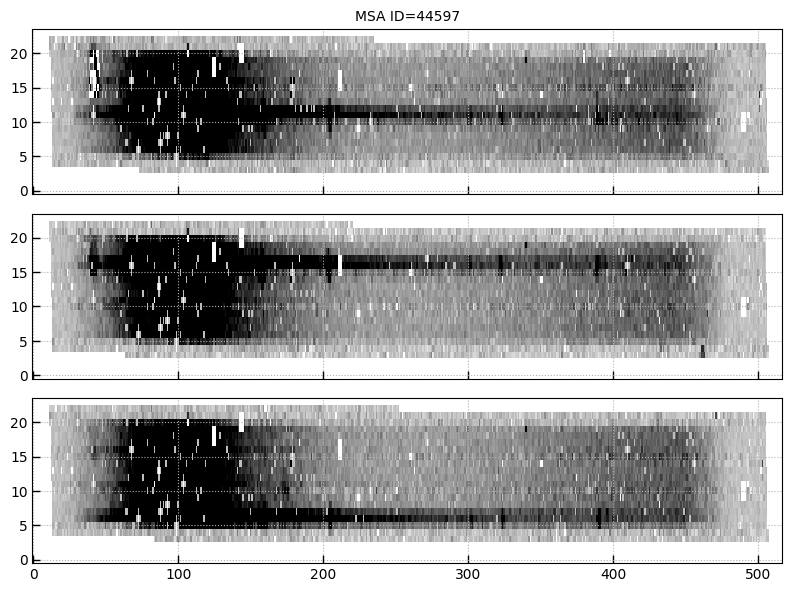

In [11]:
fig, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True, sharey=True)

for ax, file in zip(axes, slit_files):
    dm = jwst.datamodels.open(file)
    ax.imshow(
        dm.data * (dm.dq == 0), vmin=-1, vmax=3, aspect="auto", cmap="gray_r"
    )
    ax.grid()

axes[0].set_title(f"MSA ID={source_ids[0]}")
fig.tight_layout(pad=1)

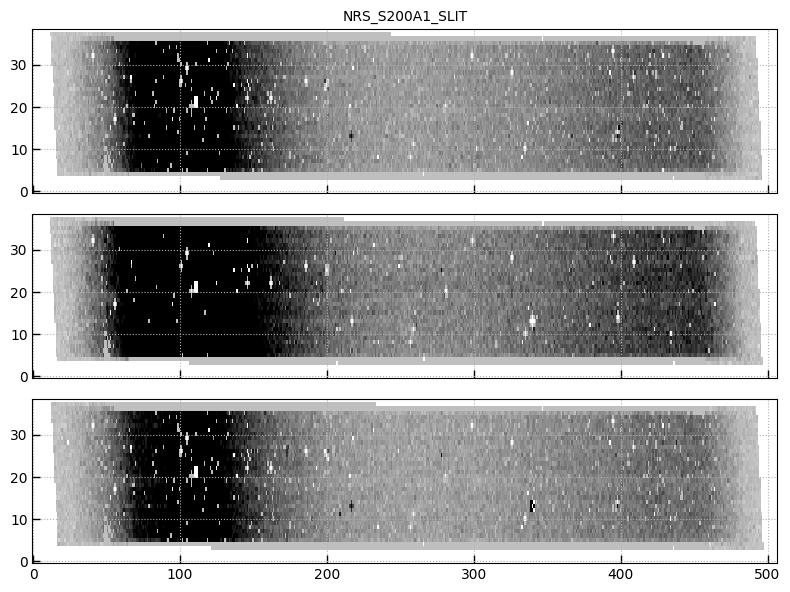

In [12]:
fig, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True, sharey=True)

for ax, file in zip(axes, fs_files):
    dm = jwst.datamodels.open(file)
    ax.imshow(
        dm.data * (dm.dq == 0), vmin=-1, vmax=3, aspect="auto", cmap="gray_r"
    )
    ax.grid()

axes[0].set_title(dm.meta.aperture.name)
fig.tight_layout(pad=1)

## Slitlet corrections

The examples below show some corrections applied to the Slit cutouts.  In practice, these don't need to be performed like this and everything is done automatically in the full extraction scripts below.

In [13]:
slit = jwst.datamodels.open(slit_files[0])
# slit = jwst.datamodels.open(fs_files[0])

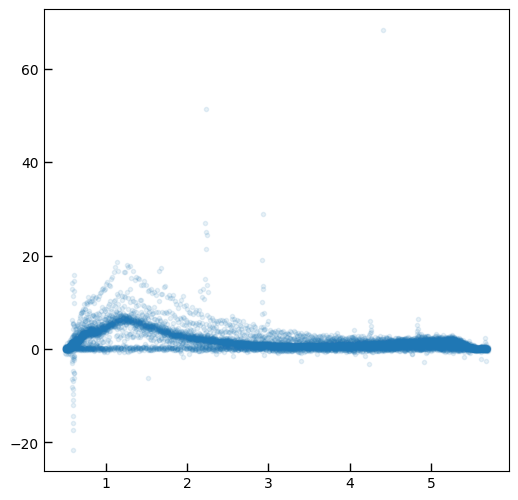

In [14]:
orig_data = slit.data * 1

slit.phot_corr = np.ones_like(slit.data)
valid_dq = slit.dq == 0

plt.scatter(slit.wavelength[valid_dq], slit.data[valid_dq], alpha=0.1)

### photometric calibration

   slit_extended_flux_calibration: msaexp_sensitivity_prism_clear_001.fits threshold=0.01 (mtime: Thu Dec  5 23:44:17 2024)


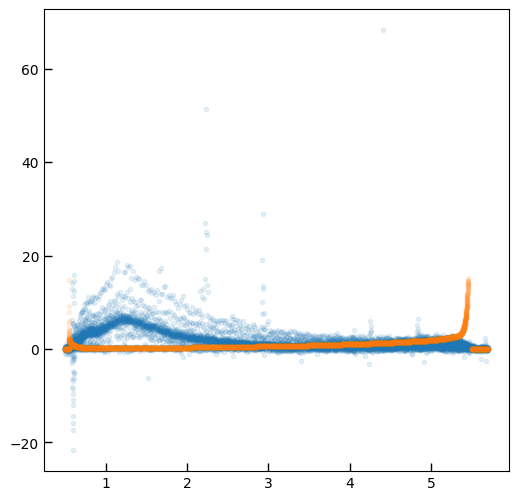

In [15]:
phot_scl = slit.meta.photometry.pixelarea_steradians * 1.0e12

extended_calibration_kwargs = {"threshold": 0.01}

status = msautils.slit_extended_flux_calibration(
    slit, **extended_calibration_kwargs
)

slit.phot_corr *= phot_scl

plt.scatter(slit.wavelength[valid_dq], slit.data[valid_dq], alpha=0.1)
plt.scatter(
    slit.wavelength[valid_dq],
    slit.phot_corr[valid_dq] * 10,
    label="phot_corr",
    alpha=0.1,
)

### FIXEDSLIT F-flat, MSA BarShadow

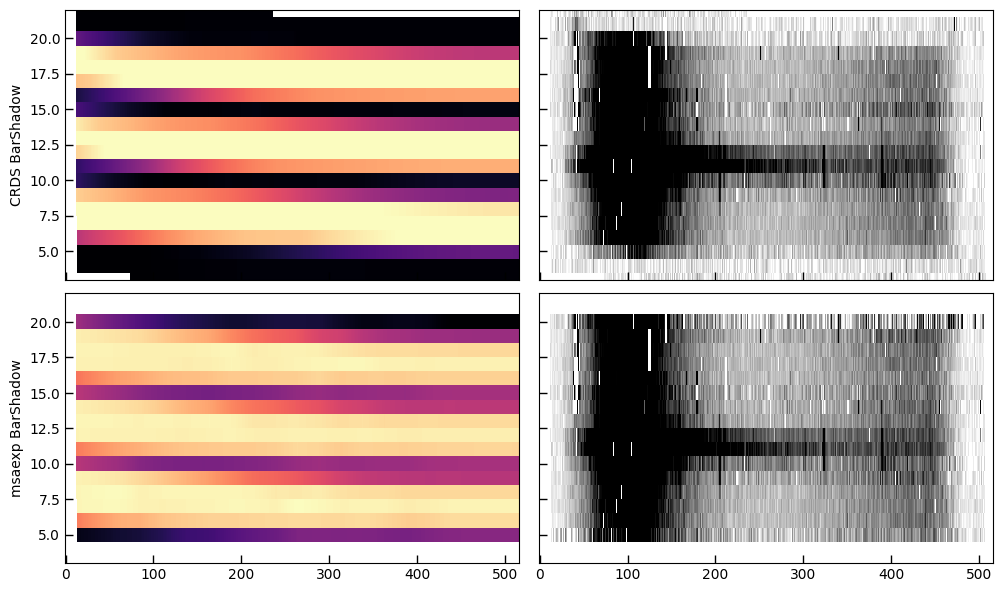

In [16]:
is_ext = msautils.slit_data_from_extended_reference(slit)

if slit.meta.exposure.type == "NRS_FIXEDSLIT":
    print("Fixed slit")
    flat_profile = msautils.fixed_slit_flat_field(
        slit, apply=True, verbose=True
    )
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    ax.imshow(flat_profile, aspect="auto")
    ax.set_title("FS Flat")

    pipeline_bar = msaexp_bar = 1.0

else:
    # BarShadow
    pipeline_bar = slit.barshadow * 1

    def get_shutter_y_coord(slit):
        wcs = slit.meta.wcs
        d2w = wcs.get_transform("detector", "world")
        d2s = wcs.get_transform("detector", "slit_frame")

        _ypi, _xpi = np.indices(slit.data.shape)
        _ras, _des, _wave = d2w(_xpi, _ypi)
        _sx, _sy, _slam = np.array(d2s(_xpi, _ypi))

        sh = slit.data.shape

        x0 = d2s(sh[1] // 2, sh[0] // 2)
        x1 = d2s(sh[1] // 2, sh[0] // 2 + 1)

        dx = np.array(x1) - np.array(x0)
        slit_shutter_scale = np.sqrt(dx[0] ** 2 + dx[1] ** 2)

        shutter_y = (_sy / slit_shutter_scale + 0.0) / 5.0

        return shutter_y

    shutter_y = get_shutter_y_coord(slit)

    msaexp_bar, bar_wrapped = msautils.get_prism_wave_bar_correction(
        shutter_y,
        slit.wavelength,
        num_shutters=3,
        wrap=False,
    )

    fig, axes = plt.subplots(2, 2, figsize=(10, 6), sharex=True, sharey=True)
    axes[0][0].imshow(pipeline_bar, aspect="auto", cmap="magma")
    axes[0][1].imshow(
        slit.data, vmin=-0.2, vmax=3, aspect="auto", cmap="gray_r"
    )

    axes[1][0].imshow(msaexp_bar, aspect="auto", cmap="magma")
    axes[1][1].imshow(
        slit.data * pipeline_bar / msaexp_bar,
        vmin=-0.2,
        vmax=3,
        aspect="auto",
        cmap="gray_r",
    )

    axes[0][0].set_ylabel("CRDS BarShadow")
    axes[1][0].set_ylabel("msaexp BarShadow")

    axes[1][1].set_ylim(3, 22)

    fig.tight_layout(pad=1)

### SFlat

Field-dependence of the flat-field measured from sky spectra

Needs SFLAT correction: True
msaexp.utils: straighten sflat /Users/gbrammer/miniconda3/envs/jw312-2025/lib/python3.12/site-packages/msaexp/data/extended_sensitivity/sflat_spl_coeffs_prism_q4.fits 3
   msaexp.utils.load_sflat_data: smooth middle of sflat 0.8
   msa_slit_sflat: compute s-flat for q:4 x:291 y:50 with sflat_spl_coeffs_prism_q4.fits (mtime: Wed Nov 27 01:23:26 2024)


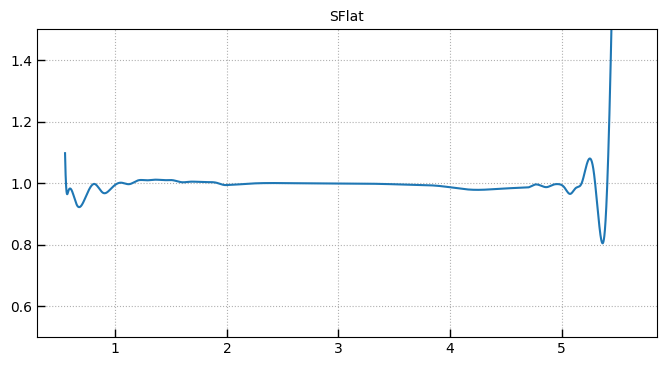

In [17]:
# SFLAT from shutter names of first exposure
needs_sflat = slit.meta.exposure.type == "NRS_MSASPEC"
needs_sflat &= msautils.slit_data_from_extended_reference(slit)
needs_sflat &= True
needs_sflat &= slit.meta.instrument.grating.upper() == "PRISM"
print(f"Needs SFLAT correction: {needs_sflat}")

if needs_sflat:
    sflat_data = msautils.msa_slit_sflat(
        slit,
        slit_wave=slit.wavelength,
        apply=False,
        force=False,
        verbose=True,
    )

    so = np.argsort(slit.wavelength.flatten())

    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    ax.plot(slit.wavelength.flatten()[so], sflat_data.flatten()[so])
    ax.set_ylim(0.5, 1.5)
    ax.grid()
    ax.set_title("SFlat")

else:
    sflat_data = 1

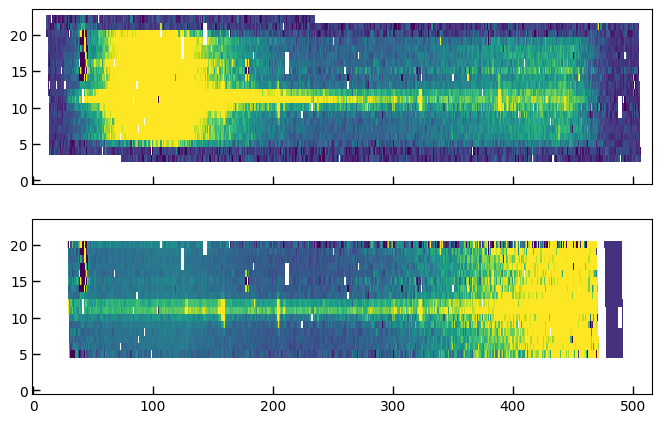

In [18]:
data_corrected = (
    slit.data * pipeline_bar / msaexp_bar / sflat_data * slit.phot_corr
)

fig, axes = plt.subplots(2, 1, figsize=(8, 5), sharex=True, sharey=True)

axes[0].imshow(orig_data, vmin=-0.5, vmax=3, aspect="auto")
axes[1].imshow(data_corrected, vmin=-0.05, vmax=0.3, aspect="auto")

# Exposure combination and spectral extraction

See the previous pipeline demonstration notebook [spectral-pipeline-2024.ipynb](https://github.com/gbrammer/msaexp/blob/main/docs/examples/spectral-pipeline-2024.ipynb) for more details on how the exposures can be combined and how the optimal profile used for the 1D extraction is fit to the data.

In [19]:
?msaexp.slit_combine.SlitGroup

Init signature:
msaexp.slit_combine.SlitGroup(
    files,
    name,
    position_key='y_index',
    diffs=True,
    grating_diffs=True,
    stuck_threshold=0.3,
    hot_cold_kwargs=None,
    bad_shutter_names=None,
    dilate_failed_open=True,
    num_shutters=-1,
    undo_barshadow=2,
    min_bar=0.4,
    bar_corr_mode='wave',
    fix_prism_norm=True,
    extended_calibration_kwargs={'threshold': 0.01},
    with_sflat_correction=True,
    with_extra_dq=True,
    slit_hotpix_kwargs={},
    sky_arrays=None,
    sky_file='read',
    set_background_spectra_kwargs={},
    global_sky_df=7,
    estimate_sky_kwargs=None,
    flag_profile_kwargs=None,
    do_multiple_mask=True,
    flag_trace_kwargs={},
    flag_percentile_kwargs={},
    undo_pathloss=True,
    trace_with_xpos=False,
    trace_with_ypos=False,
    trace_from_yoffset=True,
    with_fs_offset=False,
    fit_shutter_offset_kwargs=None,
    shutter_offset=0.0,
    nod_offset=None,
    pad_border=2,
    weight_type='ivm',
    refer

## Wrapper function for DJA/msaexp

In [20]:
from msaexp import cloud, slit_combine

Set ROOT_PATH=/usr/local/share/python/msaexp/docs/examples/msaexp-demo-2025


In [21]:
# Various keyword defaults

kws = yaml.load(
    """
drizzle_kws:
  dkws:
    oversample: 16
    pixfrac: 0.800000
  grating_limits:
    g140h:
    - 0.680000
    - 1.900000
    - 0.000238
    g140m:
    - 0.550000
    - 3.350000
    - 0.000630
    g235h:
    - 1.660000
    - 3.170000
    - 0.000396
    g235m:
    - 1.580000
    - 5.300000
    - 0.001060
    g395h:
    - 2.830000
    - 5.240000
    - 0.000666
    g395m:
    - 2.680000
    - 5.510000
    - 0.001790
    prism:
    - 0.540000
    - 5.510000
    - 0.010000
  ny: 25
  step: 1.0
  wave_sample: 1.05
  with_pathloss: true
gratings:
- PRISM
- G140M
- G235M
- G395M
- G140H
- G235H
- G395H
""",
    Loader=yaml.Loader,
)

## Perform the combination

1. Differences of nodded exposures to subtract the background
2. Fit PSF-convolved profile for optimal 1D extraction

In [22]:
msautils.SFLAT_STRAIGHTEN

3

set default s3_base = s3://msaexp-nirspec/extractions
set default rowid = None
Event data:
clean: false
drizzle_kws:
  dkws:
    oversample: 16
    pixfrac: 0.800000
  grating_limits:
    g140h:
    - 0.680000
    - 1.900000
    - 0.000238
    g140m:
    - 0.550000
    - 3.350000
    - 0.000630
    g235h:
    - 1.660000
    - 3.170000
    - 0.000396
    g235m:
    - 1.580000
    - 5.300000
    - 0.001060
    g395h:
    - 2.830000
    - 5.240000
    - 0.000666
    g395m:
    - 2.680000
    - 5.510000
    - 0.001790
    prism:
    - 0.540000
    - 5.510000
    - 0.010000
  ny: 25
  step: 1.000000
  wave_sample: 1.050000
  with_pathloss: true
files:
- jw04233006001_03101_00002_nrs1_clear_prism_raw.186.4233_44597.fits
- jw04233006001_03101_00003_nrs1_clear_prism_raw.186.4233_44597.fits
- jw04233006001_03101_00004_nrs1_clear_prism_raw.186.4233_44597.fits
fix_params: false
gratings:
- PRISM
- G140M
- G235M
- G395M
- G140H
- G235H
- G395H
initial_theta:
- 0.300000
- 0.000000
key: '4233_44597'

2025-06-26 22:50:55,746 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/jw312-2025/lib/python3.12/site-packages/jwst/wavecorr/wavecorr.py:194: RuntimeWarning: Mean of empty slice
  lam_mean = np.nanmean(lam, axis=0)

2025-06-26 22:50:55,746 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/jw312-2025/lib/python3.12/site-packages/jwst/wavecorr/wavecorr.py:195: RuntimeWarning: Mean of empty slice
  disp_mean = np.nanmean(dispersion, axis=0)



   Apply wavelength correction for source_xpos = -0.06: dx = -0.11 to -0.04 pixels
   msa_slit_sflat: compute s-flat for q:4 x:291 y:50 with sflat_spl_coeffs_prism_q4.fits (mtime: Wed Nov 27 01:23:26 2024)


2025-06-26 22:50:56,104 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/jw312-2025/lib/python3.12/site-packages/jwst/wavecorr/wavecorr.py:194: RuntimeWarning: Mean of empty slice
  lam_mean = np.nanmean(lam, axis=0)

2025-06-26 22:50:56,104 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/jw312-2025/lib/python3.12/site-packages/jwst/wavecorr/wavecorr.py:195: RuntimeWarning: Mean of empty slice
  disp_mean = np.nanmean(dispersion, axis=0)



   Apply wavelength correction for source_xpos = -0.07: dx = -0.13 to -0.06 pixels


2025-06-26 22:50:56,491 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/jw312-2025/lib/python3.12/site-packages/jwst/wavecorr/wavecorr.py:194: RuntimeWarning: Mean of empty slice
  lam_mean = np.nanmean(lam, axis=0)

2025-06-26 22:50:56,492 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/jw312-2025/lib/python3.12/site-packages/jwst/wavecorr/wavecorr.py:195: RuntimeWarning: Mean of empty slice
  disp_mean = np.nanmean(dispersion, axis=0)



   Apply wavelength correction for source_xpos = -0.05: dx = -0.09 to -0.02 pixels
 Recomputed offsets slit     : force [ 0.00,  5.07, -5.07] pix offsets
 apply_spline_bar_correction :  (mode='wave', wrap=auto, num_shutters=3)
 flag_trace_outliers         : 3 pixels  / yslit = [-2, 2]
 flag_percentile_outliers    : 7 pixels  / plevels [0.95, -4, -0.1] threshold=4.315 (dilate=True)
 flag_percentile_outliers    : calculated 0.950000 0.997586 0.999940
 multiple mask               : 11 pixels in >= 2 exposures
 fit_params_by_sn            : jw04233006001_nrs1_186-prism-clear  SN(95%) = 14.5  fix_sigma=False  degree=0 

keys: ['jw04233006001_nrs1_186-prism-clear']
 fit_params_by_sn            : jw04233006001_nrs1_186-prism-clear  SN(95%) = 14.5  fix_sigma=False  degree=0 

##### Group #1 / 1: jw04233006001_nrs1_186-prism-clear ####

msaexp.utils.LookupTablePSF: /Users/gbrammer/miniconda3/envs/jw312-2025/lib/python3.12/site-packages/msaexp/data/psf/nirspec_merged_s200a1_exp_psf_lookup_001.fi

2025-06-26 22:51:00,274 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/jw312-2025/lib/python3.12/site-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  arr.partition(

2025-06-26 22:51:00,278 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/jw312-2025/lib/python3.12/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)



msaexp.drizzle.extract_from_hdul: Initial center =    0.00, sigma =   0.31
msaexp.drizzle.extract_from_hdul: dchi2/dcenter = 24017.7
msaexp.drizzle.extract_from_hdul: aperture extraction = (25, 1)
msaexp.drizzle.extract_from_hdul:  Output center =   -0.00, sigma =   0.31
rubies-egs61-test-v4_prism-clear_4233_44597.spec.fits
rubies-egs61-test-v4_prism-clear_4233_44597.pixtab.fits


2025-06-26 22:51:00,491 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/jw312-2025/lib/python3.12/site-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  arr.partition(

2025-06-26 22:51:00,491 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/jw312-2025/lib/python3.12/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)



# (2025-06-26 20:51:00.624)
Done
rename  NCOMBINE NFILES
rename  FILENAME FILE1
rename  MSAMETFL MSAMET1
rename  MSAMETID MSAID1
rename  MSACONID MSACNF1
rename  PATT_NUM DITHN1
rename  SOURCEID SRCID
rename  SLITID SLITID1
rename  SLTSTRT1 XSTART1
rename  SLTSIZE1 XSIZE1
rename  SLTSTRT2 YSTART1
rename  SLTSIZE2 YSIZE1
rename  PA_V3 PA_V31
1 1


1it [00:00, 64.92it/s]


msamet1
msaid1
msacnf1
dithn1
slitid1
xstart1
ystart1
xsize1
ysize1
pa_v31


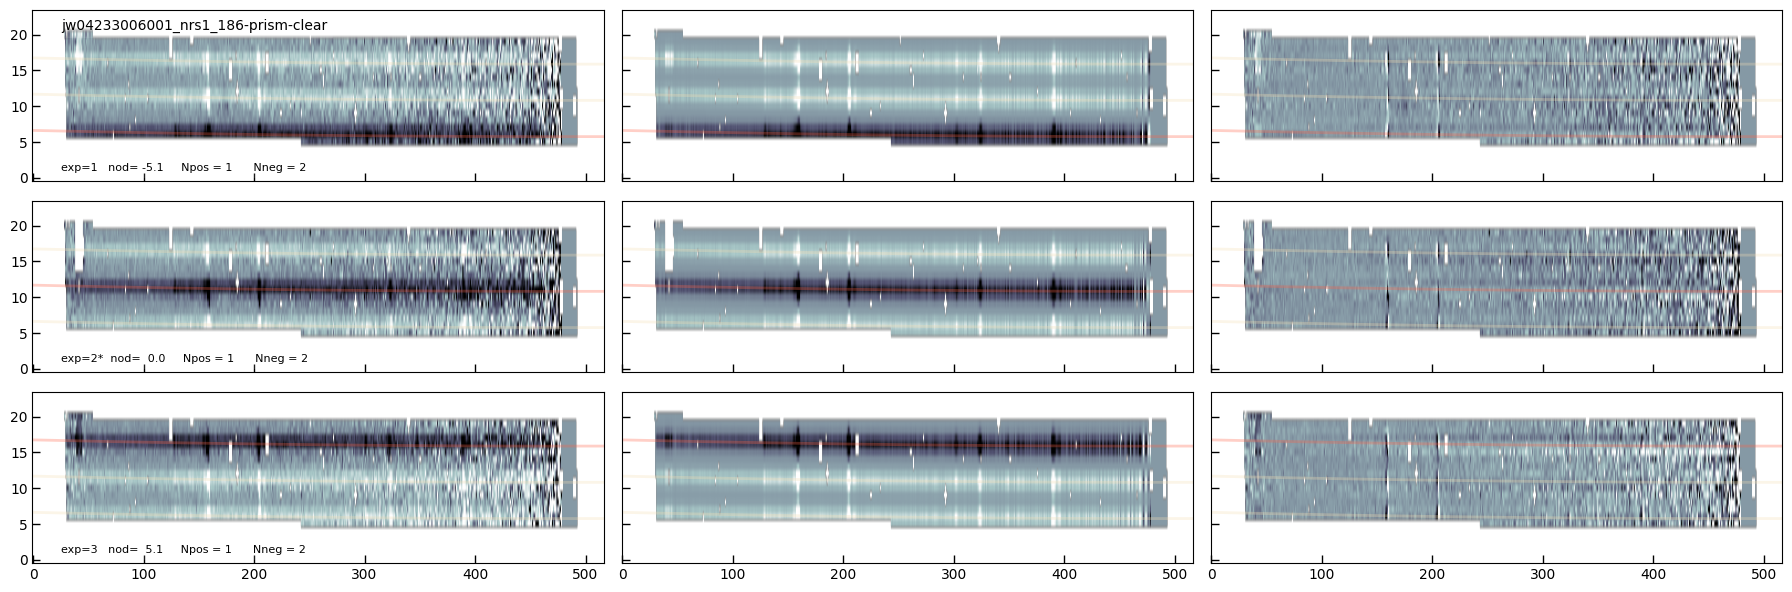

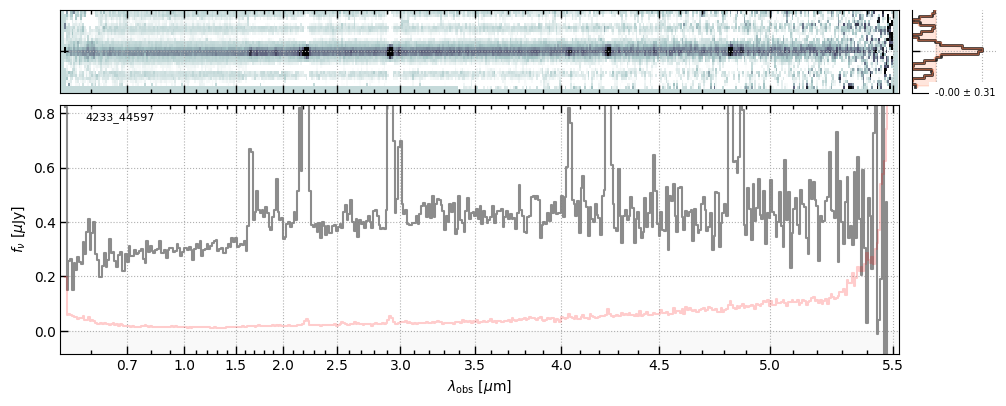

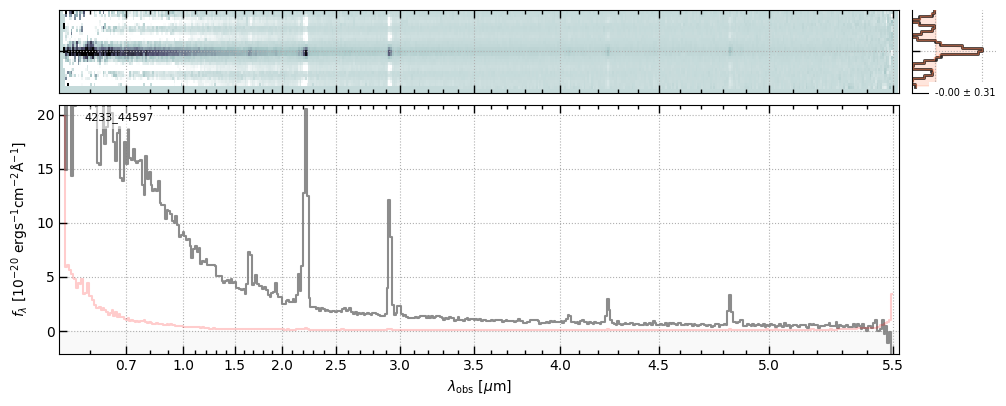

In [23]:
source_id = source_ids[0]

slit_files = glob.glob(f"jw0{prog}*{source_ids[0]}.fits")
slit_files.sort()

root = "rubies-egs61-test-v4"

extra_kwargs = {
    "pad_border": 0,
    "plot_kws": {"ny": 7},
    "recenter_type": 0,
    "sky_diffs": True,
    "initial_theta": [0.3, 0.0],
    "fix_params": False,
}

msa_obj, msa_info, msa_status = msaexp.cloud.handle_spectrum_extraction(
    sync=False,
    clean=False,
    skip_existing=False,
    files=slit_files,
    key=f"{prog}_{source_id}",
    outroot=root,
    root=root,
    yaml_kwargs=yaml.dump(extra_kwargs),
    **kws,
)

In [24]:
dja = msaexp.spectrum.SpectrumSampler(
    "https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs61-v4/rubies-egs61-v4_prism-clear_4233_44597.spec.fits"
)
local = msaexp.spectrum.SpectrumSampler(
    "rubies-egs61-test-v4_prism-clear_4233_44597.spec.fits"
)

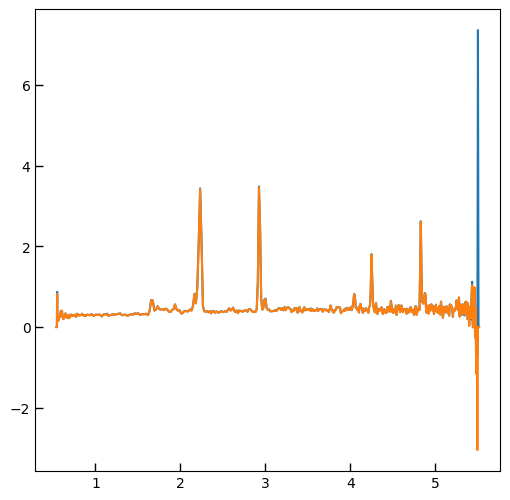

In [25]:
plt.plot(dja["wave"], dja["flux"], label="DJA v4")
plt.plot(local["wave"], local["flux"], label="Local reduction")

(0.9, 1.1)

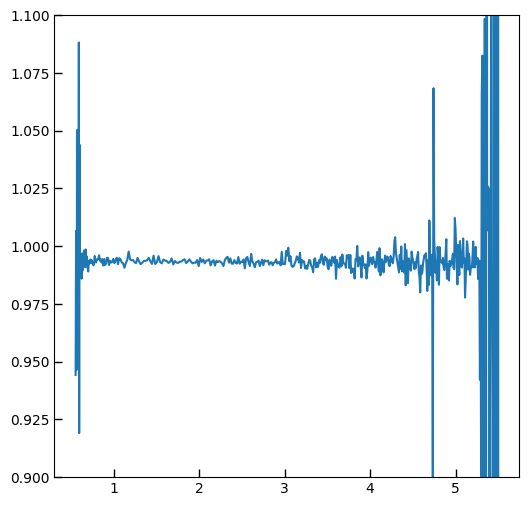

In [26]:
plt.plot(local["wave"], local["flux"] / dja["flux"])
plt.ylim(0.9, 1.1)

## FS extraction

Extract the fixed slit spectrum without nod differences to estimate the sky

set default s3_base = s3://msaexp-nirspec/extractions
set default rowid = None
Event data:
clean: false
drizzle_kws:
  dkws:
    oversample: 16
    pixfrac: 0.800000
  grating_limits:
    g140h:
    - 0.680000
    - 1.900000
    - 0.000238
    g140m:
    - 0.550000
    - 3.350000
    - 0.000630
    g235h:
    - 1.660000
    - 3.170000
    - 0.000396
    g235m:
    - 1.580000
    - 5.300000
    - 0.001060
    g395h:
    - 2.830000
    - 5.240000
    - 0.000666
    g395m:
    - 2.680000
    - 5.510000
    - 0.001790
    prism:
    - 0.540000
    - 5.510000
    - 0.010000
  ny: 25
  step: 1.000000
  wave_sample: 1.050000
  with_pathloss: true
files:
- jw01181011001_31101_00001_nrs1_goods-north_clear_prism_s200a1.fits
- jw01214003001_03101_00002_nrs1__clear_prism_s200a1.fits
- jw04233006001_03101_00002_nrs1__clear_prism_s200a1.fits
- jw04233006001_03101_00003_nrs1__clear_prism_s200a1.fits
- jw04233006001_03101_00004_nrs1__clear_prism_s200a1.fits
fix_params: true
gratings:
- PRISM
- G140M
-

2025-06-26 22:51:02,466 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/jw312-2025/lib/python3.12/site-packages/jwst/wavecorr/wavecorr.py:194: RuntimeWarning: Mean of empty slice
  lam_mean = np.nanmean(lam, axis=0)

2025-06-26 22:51:02,466 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/jw312-2025/lib/python3.12/site-packages/jwst/wavecorr/wavecorr.py:195: RuntimeWarning: Mean of empty slice
  disp_mean = np.nanmean(dispersion, axis=0)



   Apply wavelength correction for source_xpos = -922.09: dx = 0.00 to 0.00 pixels
   jw01181011001_31101_00001_nrs1_goods-north_clear_prism_s200a1.fits source_type=EXTENDED  no PATHLOSS_PS found
 Recomputed offsets slit     : force [ 0.00] pix offsets
 flag_trace_outliers         : too few pixels 0
 flag_percentile_outliers    : pixels 0 < 100

* Group jw01214003001_nrs1_s200a1-prism-clear   N=1
msaexp.utils.LookupTablePSF: /Users/gbrammer/miniconda3/envs/jw312-2025/lib/python3.12/site-packages/msaexp/data/psf/nirspec_merged_s200a1_exp_psf_lookup_001.fits
   slit_extended_flux_calibration: msaexp_sensitivity_prism_clear_001.fits threshold=0.0 (mtime: Thu Dec  5 23:44:17 2024)
   slit_extended_flux_calibration: correction for Fixed Slit NRS_S200A1_SLIT
 0 jw01214003001_03101_00002_nrs1__clear_prism_s200a1.fits (39, 506)  3 flagged hot pixels
fixed_slit_flat_field: fixed_slit_flat_profile_s200a1.yaml  (apply=True)


2025-06-26 22:51:03,479 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/jw312-2025/lib/python3.12/site-packages/jwst/wavecorr/wavecorr.py:194: RuntimeWarning: Mean of empty slice
  lam_mean = np.nanmean(lam, axis=0)

2025-06-26 22:51:03,480 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/jw312-2025/lib/python3.12/site-packages/jwst/wavecorr/wavecorr.py:195: RuntimeWarning: Mean of empty slice
  disp_mean = np.nanmean(dispersion, axis=0)



   Apply wavelength correction for source_xpos = -210.01: dx = 0.00 to 0.00 pixels
   jw01214003001_03101_00002_nrs1__clear_prism_s200a1.fits source_type=EXTENDED  no PATHLOSS_PS found
 Recomputed offsets slit     : force [ 0.00] pix offsets
 flag_trace_outliers         : too few pixels 0
 flag_percentile_outliers    : pixels 0 < 100

* Group jw04233006001_nrs1_s200a1-prism-clear   N=3
msaexp.utils.LookupTablePSF: /Users/gbrammer/miniconda3/envs/jw312-2025/lib/python3.12/site-packages/msaexp/data/psf/nirspec_merged_s200a1_exp_psf_lookup_001.fits
   slit_extended_flux_calibration: msaexp_sensitivity_prism_clear_001.fits threshold=0.0 (mtime: Thu Dec  5 23:44:17 2024)
   slit_extended_flux_calibration: correction for Fixed Slit NRS_S200A1_SLIT
   slit_extended_flux_calibration: msaexp_sensitivity_prism_clear_001.fits threshold=0.0 (mtime: Thu Dec  5 23:44:17 2024)
   slit_extended_flux_calibration: correction for Fixed Slit NRS_S200A1_SLIT
   slit_extended_flux_calibration: msaexp_sensit

2025-06-26 22:51:05,669 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/jw312-2025/lib/python3.12/site-packages/jwst/wavecorr/wavecorr.py:194: RuntimeWarning: Mean of empty slice
  lam_mean = np.nanmean(lam, axis=0)

2025-06-26 22:51:05,669 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/jw312-2025/lib/python3.12/site-packages/jwst/wavecorr/wavecorr.py:195: RuntimeWarning: Mean of empty slice
  disp_mean = np.nanmean(dispersion, axis=0)



   Apply wavelength correction for source_xpos = -484.30: dx = 0.00 to 0.00 pixels


2025-06-26 22:51:05,955 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/jw312-2025/lib/python3.12/site-packages/jwst/wavecorr/wavecorr.py:194: RuntimeWarning: Mean of empty slice
  lam_mean = np.nanmean(lam, axis=0)

2025-06-26 22:51:05,956 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/jw312-2025/lib/python3.12/site-packages/jwst/wavecorr/wavecorr.py:195: RuntimeWarning: Mean of empty slice
  disp_mean = np.nanmean(dispersion, axis=0)



   Apply wavelength correction for source_xpos = -484.31: dx = 0.00 to 0.00 pixels


2025-06-26 22:51:06,243 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/jw312-2025/lib/python3.12/site-packages/jwst/wavecorr/wavecorr.py:194: RuntimeWarning: Mean of empty slice
  lam_mean = np.nanmean(lam, axis=0)

2025-06-26 22:51:06,243 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/jw312-2025/lib/python3.12/site-packages/jwst/wavecorr/wavecorr.py:195: RuntimeWarning: Mean of empty slice
  disp_mean = np.nanmean(dispersion, axis=0)



   Apply wavelength correction for source_xpos = -484.28: dx = 0.00 to 0.00 pixels
   jw04233006001_03101_00002_nrs1__clear_prism_s200a1.fits source_type=EXTENDED  no PATHLOSS_PS found
   jw04233006001_03101_00003_nrs1__clear_prism_s200a1.fits source_type=EXTENDED  no PATHLOSS_PS found
   jw04233006001_03101_00004_nrs1__clear_prism_s200a1.fits source_type=EXTENDED  no PATHLOSS_PS found
 Recomputed offsets slit     : force [ 0.00,  5.01, -5.01] pix offsets
 flag_trace_outliers         : 130 pixels  / yslit = [-2, 2]
 flag_percentile_outliers    : 22 pixels  / plevels [0.95, -4, -0.1] threshold=2.161 (dilate=True)
 flag_percentile_outliers    : calculated 0.950000 0.993080 0.999827
 multiple mask               : 20 pixels in >= 2 exposures
 fit_params_by_sn            : jw01181011001_nrs1_s200a1-prism-clear  SN(95%) = 19.9  fix_sigma=False  degree=0 
 fit_params_by_sn            : jw01214003001_nrs1_s200a1-prism-clear  SN(95%) = 24.9  fix_sigma=False  degree=0 
 fit_params_by_sn         

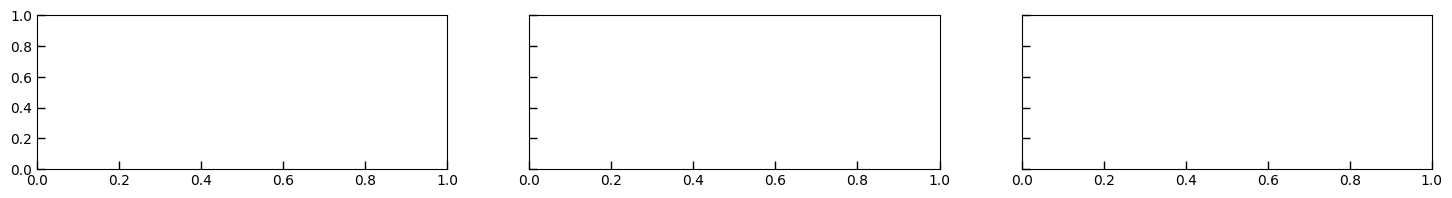

In [27]:
extra_kwargs = {
    "pad_border": 0,
    "plot_kws": {"ny": 7},
    "recenter_type": 0,
    "sky_diffs": False,
    "with_fs_offset": False,
    "initial_theta": [
        0.2,
        15,
    ],  # Force extraction at rough middle
    "fix_params": True,
}

fs_obj, fs_info, fs_status = msaexp.cloud.handle_spectrum_extraction(
    sync=False,
    clean=False,
    skip_existing=False,
    files=fs_files,
    key=f"{prog}_{fixed_slit.lower()}",
    outroot=root,
    root=root,
    yaml_kwargs=yaml.dump(extra_kwargs),
    **kws,
)

In [28]:
pixtab_files = glob.glob("*4233*pixtab.fits")
pixtab_files.sort()

msa_ptab = utils.read_catalog(pixtab_files[0])

pixtab_files = glob.glob("*s200*pixtab.fits")
pixtab_files.sort()
ptab = utils.read_catalog(pixtab_files[0])

['sci', 'sky', 'var_total', 'var_rnoise', 'wave', 'dwave_dx', 'yslit', 'bar', 'profile', 'pathloss', 'exposure_index', 'exptime']


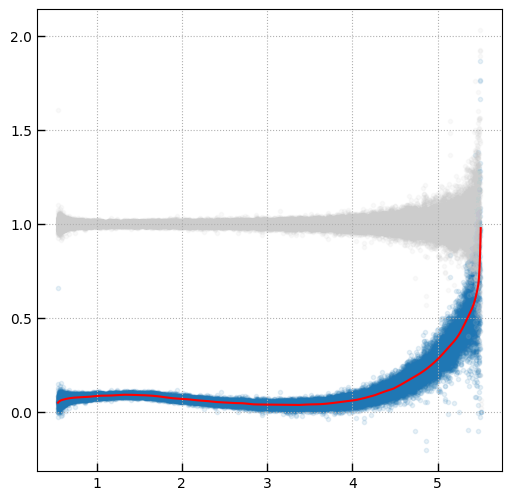

In [29]:
plt.scatter(ptab["wave"], ptab["sci"], alpha=0.1)

df = 51

bspl = utils.bspline_templates(
    ptab["wave"], df=df, get_matrix=True, minmax=(0.5, 5.8)
)

print(ptab.colnames)
trim = ptab["var_total"] > 0

spl_coeffs = np.linalg.lstsq(
    (bspl.T / np.sqrt(ptab["var_total"])).T[trim, :],
    (ptab["sci"] / np.sqrt(ptab["var_total"]))[trim],
    rcond=None,
)
spl_model = bspl.dot(spl_coeffs[0])

so = np.argsort(ptab["wave"])
plt.plot(ptab["wave"][so], spl_model[so], color="r")

plt.scatter(
    ptab["wave"][so],
    (ptab["sci"][so] - spl_model[so]) + 1,
    color="0.8",
    alpha=0.1,
)
plt.grid()

### Set sky arrays from the fit to the FS spectrum and re-extract

The FS sky spectrum doesn't quite match that in the MSA shutters, perhaps due to residuals in the S-Flat correction. 


In [30]:
kwargs = yaml.load(
    """
cross_dispersion_mask_type: trace
degree_kwargs: {}
diffs: false
do_gratings:
- PRISM
- G140M
- G235M
- G395M
- G140H
- G235H
- G395H
drizzle_kws:
  dkws:
    oversample: 16
    pixfrac: 0.800000
  grating_limits:
    g140h:
    - 0.680000
    - 1.900000
    - 0.000238
    g140m:
    - 0.550000
    - 3.350000
    - 0.000630
    g235h:
    - 1.660000
    - 3.170000
    - 0.000396
    g235m:
    - 1.580000
    - 5.300000
    - 0.001060
    g395h:
    - 2.830000
    - 5.240000
    - 0.000666
    g395m:
    - 2.680000
    - 5.510000
    - 0.001790
    prism:
    - 0.540000
    - 5.510000
    - 0.010000
  ny: 25
  step: 1.000000
  wave_sample: 1.050000
  with_pathloss: true
files:
- jw04233006001_03101_00002_nrs1_clear_prism_raw.186.4233_44597.fits
- jw04233006001_03101_00003_nrs1_clear_prism_raw.186.4233_44597.fits
- jw04233006001_03101_00004_nrs1_clear_prism_raw.186.4233_44597.fits
fit_params_kwargs:
  degree_sn:
  - - -10000
  - - 0
  sigma_threshold: 0
  sn_percentile: 95
  theta:
  - 0.200000
  - 15
  verbose: true
fit_type: 1
fix_params: false
free_trace_offset: false
get_background: false
get_xobj: true
include_full_pixtab:
- PRISM
initial_sigma: 5
initial_theta:
- 0.300000
- 0.000000
input_fix_sigma: null
join:
- 0
- 3
- 7
lookup_prf_type: merged
lookup_prf_version: '001'
make_2d_plots: 2
mask_cross_dispersion: null
nod_offset: null
offset_degree: 1
pad_border: 0
path_to_files: ./
plot_kws:
  ny: 7
position_key: y_index
recenter_all: false
reference_exposure: auto
root: rubies-egs61-test-v4
sort_by_sn: true
split_uncover: 1
stuck_threshold: 0.300000
target: '4233_44597'
trace_from_yoffset: true
trace_niter: 4
trace_with_xpos: true
trace_with_ypos: auto
undo_barshadow: 2
undo_pathloss: 1
use_first_sky: false
valid_frac_threshold: 0.100000
""",
    Loader=yaml.Loader,
)

In [31]:
kwargs["target"] = f"{prog}_{source_id}"
kwargs["files"] = glob.glob(f"*raw*{prog}_{source_id}.fits")

# Don't use this with the v4 SFlat correction
kwargs["fix_prism_norm"] = False

kwargs["sky_arrays"] = (ptab["wave"][so], spl_model[so])
kwargs["sky_file"] = None

# Use sky_arrays as-is
kwargs["estimate_sky_kwargs"] = None

kwargs["diffs"] = False

# (2025-06-26 20:51:07.291)

slit_combine.extract_spectra(**{'target': '4233_44597', 'root': 'rubies-egs61-test-v4', 'path_to_files': './', 'files': ['jw04233006001_03101_00002_nrs1_clear_prism_raw.186.4233_44597.fits', 'jw04233006001_03101_00004_nrs1_clear_prism_raw.186.4233_44597.fits', 'jw04233006001_03101_00003_nrs1_clear_prism_raw.186.4233_44597.fits'], 'do_gratings': ['PRISM', 'G140M', 'G235M', 'G395M', 'G140H', 'G235H', 'G395H'], 'join': [0, 3, 7], 'split_uncover': 1, 'stuck_threshold': 0.3, 'valid_frac_threshold': 0.1, 'pad_border': 0, 'sort_by_sn': True, 'position_key': 'y_index', 'mask_cross_dispersion': None, 'cross_dispersion_mask_type': 'trace', 'trace_from_yoffset': True, 'reference_exposure': 'auto', 'trace_niter': 4, 'offset_degree': 1, 'degree_kwargs': {}, 'recenter_all': False, 'free_trace_offset': False, 'nod_offset': None, 'initial_sigma': 5, 'fit_type': 1, 'initial_theta': [0.3, 0.0], 'fix_params': False, 'input_fix_sigma': None, 'fit_params_kwargs': {'degree_sn': 

2025-06-26 22:51:08,862 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/jw312-2025/lib/python3.12/site-packages/jwst/wavecorr/wavecorr.py:194: RuntimeWarning: Mean of empty slice
  lam_mean = np.nanmean(lam, axis=0)

2025-06-26 22:51:08,862 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/jw312-2025/lib/python3.12/site-packages/jwst/wavecorr/wavecorr.py:195: RuntimeWarning: Mean of empty slice
  disp_mean = np.nanmean(dispersion, axis=0)



   Apply wavelength correction for source_xpos = -0.06: dx = -0.11 to -0.04 pixels
   msa_slit_sflat: compute s-flat for q:4 x:291 y:50 with sflat_spl_coeffs_prism_q4.fits (mtime: Wed Nov 27 01:23:26 2024)


2025-06-26 22:51:09,322 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/jw312-2025/lib/python3.12/site-packages/jwst/wavecorr/wavecorr.py:194: RuntimeWarning: Mean of empty slice
  lam_mean = np.nanmean(lam, axis=0)

2025-06-26 22:51:09,322 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/jw312-2025/lib/python3.12/site-packages/jwst/wavecorr/wavecorr.py:195: RuntimeWarning: Mean of empty slice
  disp_mean = np.nanmean(dispersion, axis=0)



   Apply wavelength correction for source_xpos = -0.07: dx = -0.13 to -0.06 pixels


2025-06-26 22:51:09,611 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/jw312-2025/lib/python3.12/site-packages/jwst/wavecorr/wavecorr.py:194: RuntimeWarning: Mean of empty slice
  lam_mean = np.nanmean(lam, axis=0)

2025-06-26 22:51:09,612 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/jw312-2025/lib/python3.12/site-packages/jwst/wavecorr/wavecorr.py:195: RuntimeWarning: Mean of empty slice
  disp_mean = np.nanmean(dispersion, axis=0)



   Apply wavelength correction for source_xpos = -0.05: dx = -0.09 to -0.02 pixels
 Recomputed offsets slit     : force [ 0.00,  5.07, -5.07] pix offsets
 apply_spline_bar_correction :  (mode='wave', wrap=auto, num_shutters=3)
 flag_trace_outliers         : 2 pixels  / yslit = [-2, 2]
 flag_percentile_outliers    : 0 pixels  / plevels [0.95, -4, -0.1] threshold=2.792 (dilate=True)
 flag_percentile_outliers    : calculated 0.950000 0.997552 0.999939
 multiple mask               : 4 pixels in >= 2 exposures
 fit_params_by_sn            : jw04233006001_nrs1_186-prism-clear  SN(95%) = 16.7  fix_sigma=False  degree=0 

keys: ['jw04233006001_nrs1_186-prism-clear']
 fit_params_by_sn            : jw04233006001_nrs1_186-prism-clear  SN(95%) = 16.7  fix_sigma=False  degree=0 

##### Group #1 / 1: jw04233006001_nrs1_186-prism-clear ####

msaexp.utils.LookupTablePSF: /Users/gbrammer/miniconda3/envs/jw312-2025/lib/python3.12/site-packages/msaexp/data/psf/nirspec_merged_s200a1_exp_psf_lookup_001.fit

2025-06-26 22:51:11,471 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/jw312-2025/lib/python3.12/site-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  arr.partition(

2025-06-26 22:51:11,489 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/jw312-2025/lib/python3.12/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)



msaexp.drizzle.extract_from_hdul: Initial center =    0.00, sigma =   0.38
msaexp.drizzle.extract_from_hdul: dchi2/dcenter = 33030.0
msaexp.drizzle.extract_from_hdul: aperture extraction = (25, 1)
msaexp.drizzle.extract_from_hdul:  Output center =   -0.00, sigma =   0.38
rubies-egs61-test-v4_prism-clear_4233_44597.spec.fits
rubies-egs61-test-v4_prism-clear_4233_44597.pixtab.fits


2025-06-26 22:51:11,660 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/jw312-2025/lib/python3.12/site-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  arr.partition(

2025-06-26 22:51:11,661 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/jw312-2025/lib/python3.12/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)



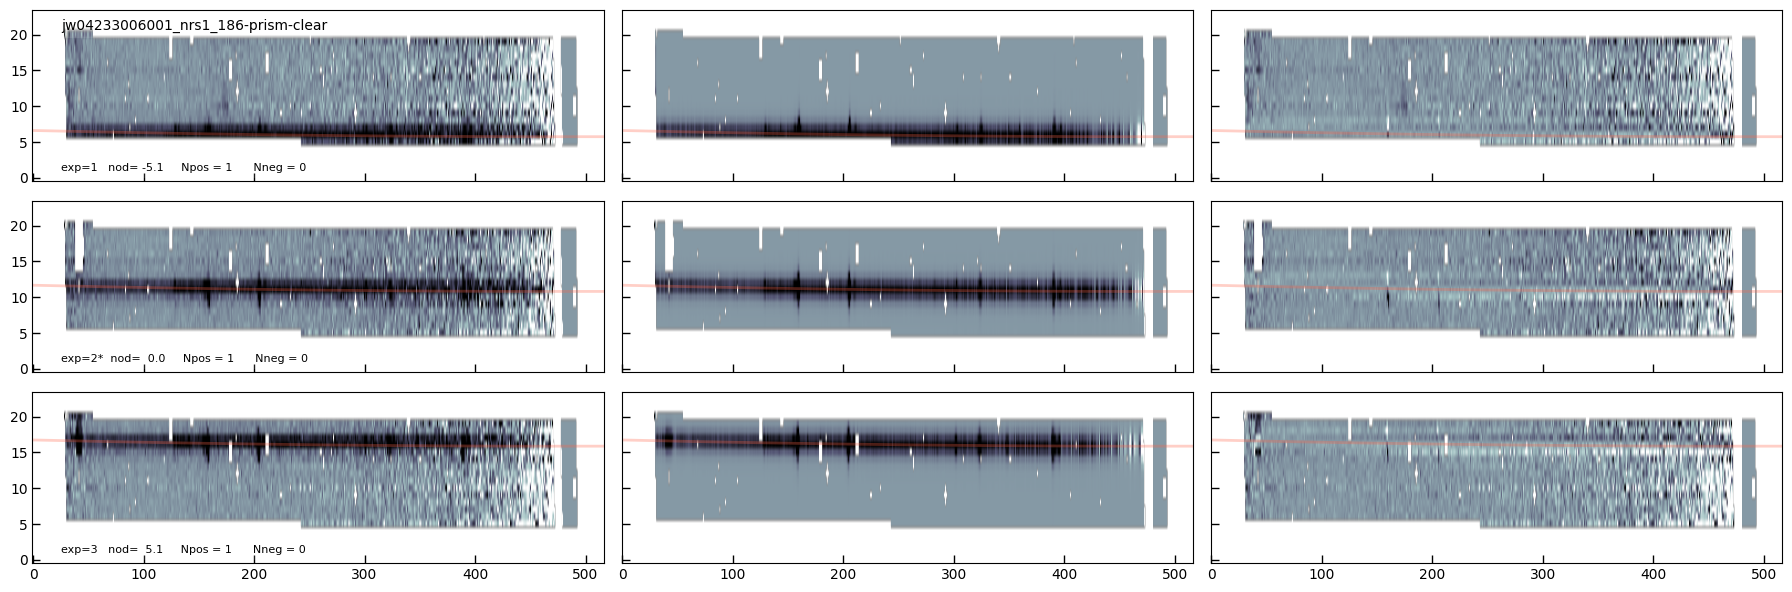

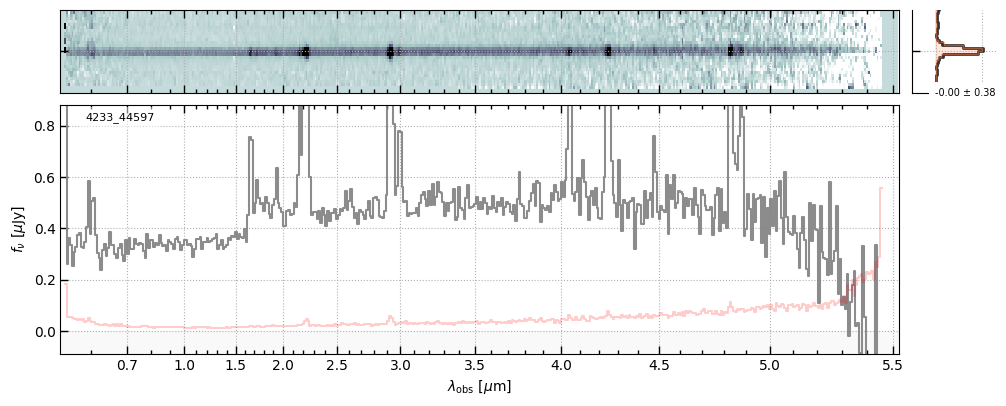

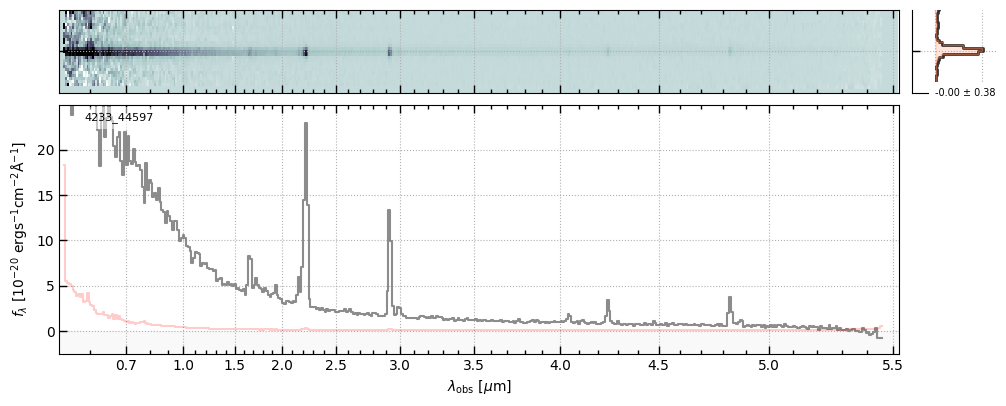

In [32]:
_ = slit_combine.extract_spectra(**kwargs)

# (2025-06-26 20:51:12.408)

slit_combine.extract_spectra(**{'target': '4233_44597', 'root': 'rubies-egs61-test-v4', 'path_to_files': './', 'files': ['jw04233006001_03101_00002_nrs1_clear_prism_raw.186.4233_44597.fits', 'jw04233006001_03101_00003_nrs1_clear_prism_raw.186.4233_44597.fits', 'jw04233006001_03101_00004_nrs1_clear_prism_raw.186.4233_44597.fits'], 'do_gratings': ['PRISM', 'G140M', 'G235M', 'G395M', 'G140H', 'G235H', 'G395H'], 'join': [0, 3, 7], 'split_uncover': 1, 'stuck_threshold': 0.3, 'valid_frac_threshold': 0.1, 'pad_border': 0, 'sort_by_sn': True, 'position_key': 'y_index', 'mask_cross_dispersion': None, 'cross_dispersion_mask_type': 'trace', 'trace_from_yoffset': True, 'reference_exposure': 'auto', 'trace_niter': 4, 'offset_degree': 1, 'degree_kwargs': {}, 'recenter_all': False, 'free_trace_offset': False, 'nod_offset': None, 'initial_sigma': 5, 'fit_type': 1, 'initial_theta': [0.3, 0.0], 'fix_params': False, 'input_fix_sigma': None, 'fit_params_kwargs': {'degree_sn': 

2025-06-26 22:51:14,016 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/jw312-2025/lib/python3.12/site-packages/jwst/wavecorr/wavecorr.py:194: RuntimeWarning: Mean of empty slice
  lam_mean = np.nanmean(lam, axis=0)

2025-06-26 22:51:14,017 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/jw312-2025/lib/python3.12/site-packages/jwst/wavecorr/wavecorr.py:195: RuntimeWarning: Mean of empty slice
  disp_mean = np.nanmean(dispersion, axis=0)



   Apply wavelength correction for source_xpos = -0.06: dx = -0.11 to -0.04 pixels
   msa_slit_sflat: compute s-flat for q:4 x:291 y:50 with sflat_spl_coeffs_prism_q4.fits (mtime: Wed Nov 27 01:23:26 2024)


2025-06-26 22:51:14,393 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/jw312-2025/lib/python3.12/site-packages/jwst/wavecorr/wavecorr.py:194: RuntimeWarning: Mean of empty slice
  lam_mean = np.nanmean(lam, axis=0)

2025-06-26 22:51:14,393 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/jw312-2025/lib/python3.12/site-packages/jwst/wavecorr/wavecorr.py:195: RuntimeWarning: Mean of empty slice
  disp_mean = np.nanmean(dispersion, axis=0)



   Apply wavelength correction for source_xpos = -0.07: dx = -0.13 to -0.06 pixels


2025-06-26 22:51:14,824 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/jw312-2025/lib/python3.12/site-packages/jwst/wavecorr/wavecorr.py:194: RuntimeWarning: Mean of empty slice
  lam_mean = np.nanmean(lam, axis=0)

2025-06-26 22:51:14,825 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/jw312-2025/lib/python3.12/site-packages/jwst/wavecorr/wavecorr.py:195: RuntimeWarning: Mean of empty slice
  disp_mean = np.nanmean(dispersion, axis=0)



   Apply wavelength correction for source_xpos = -0.05: dx = -0.09 to -0.02 pixels
 Recomputed offsets slit     : force [ 0.00,  5.07, -5.07] pix offsets
 apply_spline_bar_correction :  (mode='wave', wrap=auto, num_shutters=3)
 flag_trace_outliers         : 2 pixels  / yslit = [-2, 2]
 flag_percentile_outliers    : 0 pixels  / plevels [0.95, -4, -0.1] threshold=2.792 (dilate=True)
 flag_percentile_outliers    : calculated 0.950000 0.997552 0.999939
 estimate_sky                : 305 outliers > 7  / N=3936 sky pixels 
 flag_trace_outliers         : 0 pixels  / yslit = [-2, 2]
 flag_percentile_outliers    : 0 pixels  / plevels [0.95, -4, -0.1] threshold=2.784 (dilate=True)
 flag_percentile_outliers    : calculated 0.950000 0.997552 0.999939
 multiple mask               : 101 pixels in >= 2 exposures
 fit_params_by_sn            : jw04233006001_nrs1_186-prism-clear  SN(95%) = 16.4  fix_sigma=False  degree=0 

keys: ['jw04233006001_nrs1_186-prism-clear']
 fit_params_by_sn            : jw04

2025-06-26 22:51:16,738 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/jw312-2025/lib/python3.12/site-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  arr.partition(

2025-06-26 22:51:16,746 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/jw312-2025/lib/python3.12/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)



msaexp.drizzle.extract_from_hdul: Initial center =    0.00, sigma =   0.33
msaexp.drizzle.extract_from_hdul: dchi2/dcenter = 31104.1
msaexp.drizzle.extract_from_hdul: aperture extraction = (25, 1)
msaexp.drizzle.extract_from_hdul:  Output center =    0.00, sigma =   0.33
rubies-egs61-test-v4_prism-clear_4233_44597.spec.fits
rubies-egs61-test-v4_prism-clear_4233_44597.pixtab.fits


2025-06-26 22:51:16,941 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/jw312-2025/lib/python3.12/site-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  arr.partition(

2025-06-26 22:51:16,942 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/jw312-2025/lib/python3.12/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)



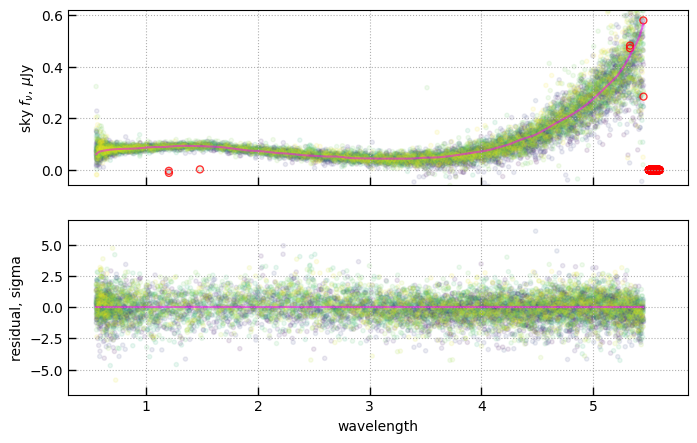

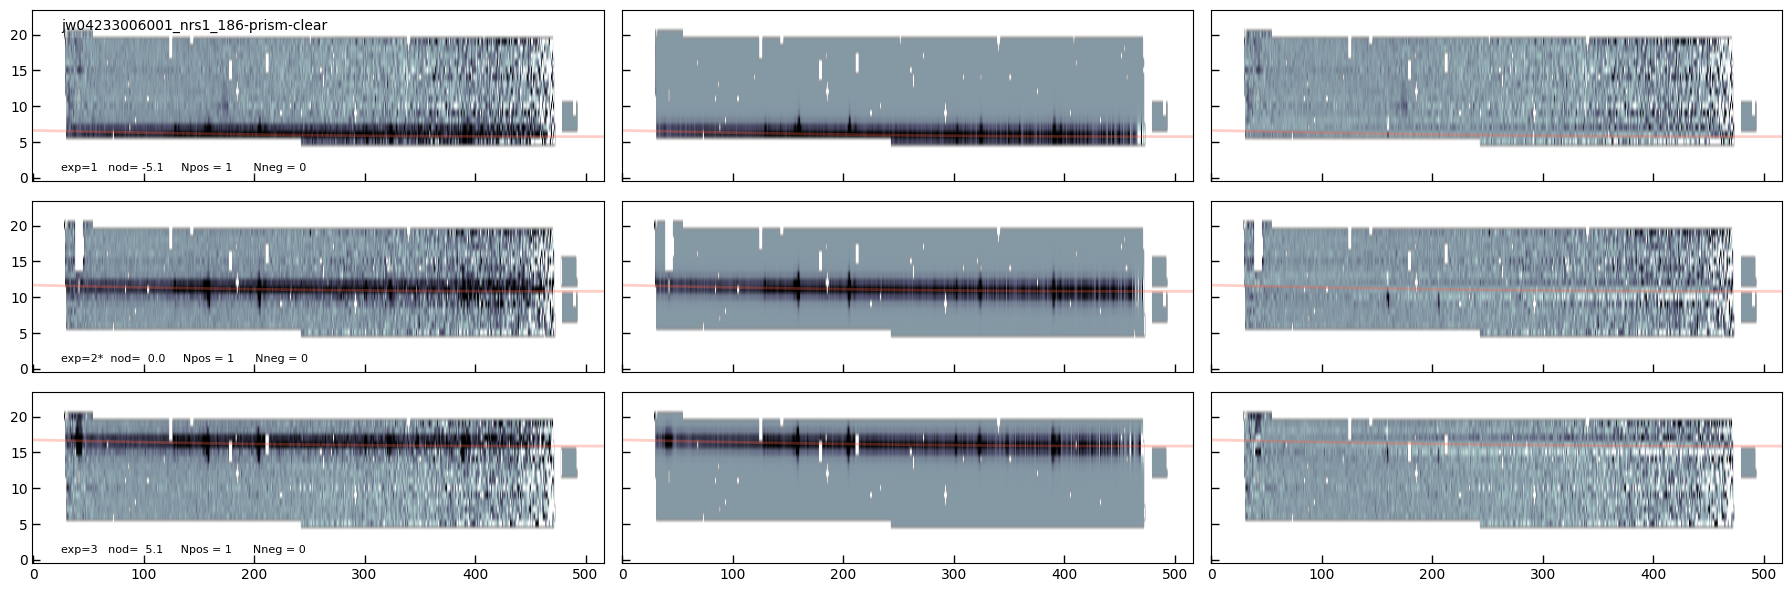

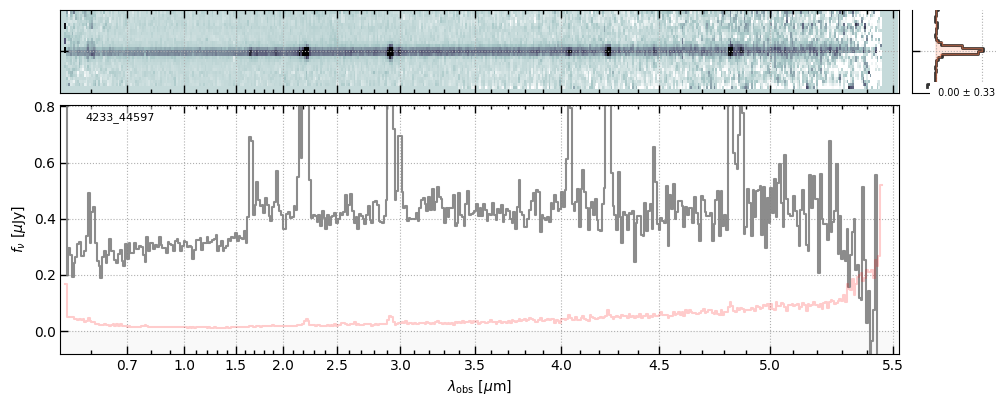

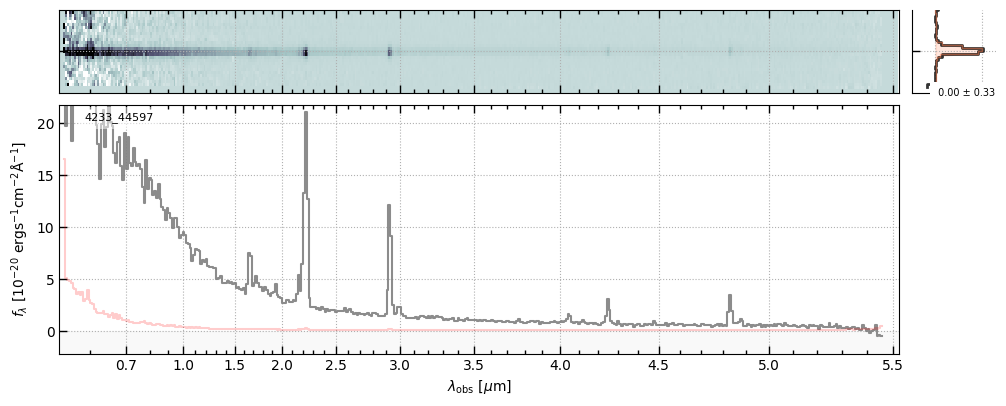

In [33]:
# derive a polynomial correction to the sky_arrays
kwargs["estimate_sky_kwargs"] = {"df": 5, "make_plot": True}
kwargs["global_sky_df"] = 13

_ = slit_combine.extract_spectra(**kwargs)

# FS example where there is something in the FS

A few programs have obtained MSA spectra while also explicitly putting a science target in one of the fixed slits.  This is also now a supported mode in APT.

In [34]:
# JWST observing program ID
prog = 1222

outroot = "gto-ulas-j1120+0641"

mask_query = mastquery.jwst.make_query_filter(
    "visit_id", values=["01222005001"]
)

gratings = ["g140h"]
detectors = ["nrs1", "nrs2"]  # limit to NRS1 for the example

# Query NIRSpec data for a program name
masks = pipeline.query_program(
    prog,
    download=True,
    detectors=detectors,
    gratings=gratings,
    extensions=["uncal", "s2d"],
    extra_filters=mask_query,
)

rate_files = glob.glob(f"jw0{prog}*rate.fits")
rate_files.sort()

print("\n".join(rate_files))
print(len(masks))

jw01222005001_03101_00001_nrs1_rate.fits
jw01222005001_03101_00001_nrs2_rate.fits
jw01222005001_03101_00002_nrs1_rate.fits
jw01222005001_03101_00002_nrs2_rate.fits
jw01222005001_03101_00003_nrs1_rate.fits
jw01222005001_03101_00003_nrs2_rate.fits
jw01222005001_05101_00001_nrs1_rate.fits
jw01222005001_05101_00001_nrs2_rate.fits
jw01222005001_09101_00001_nrs1_rate.fits
jw01222005001_09101_00001_nrs2_rate.fits
jw01222005001_09101_00002_nrs1_rate.fits
jw01222005001_09101_00002_nrs2_rate.fits
jw01222005001_09101_00003_nrs1_rate.fits
jw01222005001_09101_00003_nrs2_rate.fits
12


In [35]:
# quasar put in S200A1 for first 6
# S200A2 for last 6
fixed_slit = "S200A1"

for file in rate_files[:6]:

    product = file.replace("_rate.fits", "_fs-photom.fits")
    if os.path.exists(product):
        print(f"{file}  ({fixed_slit} FS already completed)")
        continue

    print(f"\nPreprocess {file} as FS {fixed_slit}\n")

    preprocess_nirspec_file(
        rate_file=file,
        root="rubies-egs61-vx",
        fixed_slit=fixed_slit,
        rename_f070=False,
        context="jwst_1225.pmap",
        clean=False,
        extend_wavelengths=True,
        undo_flat=True,
        by_source=False,
    )

jw01222005001_03101_00001_nrs1_rate.fits  (S200A1 FS already completed)
jw01222005001_03101_00001_nrs2_rate.fits  (S200A1 FS already completed)
jw01222005001_03101_00002_nrs1_rate.fits  (S200A1 FS already completed)
jw01222005001_03101_00002_nrs2_rate.fits  (S200A1 FS already completed)
jw01222005001_03101_00003_nrs1_rate.fits  (S200A1 FS already completed)
jw01222005001_03101_00003_nrs2_rate.fits  (S200A1 FS already completed)


In [36]:
fs_files = glob.glob(f"jw0{prog}*_s200*fits")
fs_files.sort()

extra_kwargs = {
    "pad_border": 0,
    "plot_kws": {"ny": 7},
    "recenter_type": 0,
    "sky_diffs": False,
    "with_fs_offset": True,
    "initial_theta": [
        2.0,
        -16.5,
    ],
    "fix_params": False,
    "flag_trace_kwargs": None,
    "flag_percentile_kwargs": None,
    "trace_with_xpos": False,
    "trace_with_ypos": False,
    "trace_from_yoffset": False,
}

# msaexp.slit_combine.CENTER_WIDTH = 0.1

set default s3_base = s3://msaexp-nirspec/extractions
set default rowid = None
Event data:
clean: false
drizzle_kws:
  dkws:
    oversample: 16
    pixfrac: 0.800000
  grating_limits:
    g140h:
    - 0.680000
    - 1.900000
    - 0.000238
    g140m:
    - 0.550000
    - 3.350000
    - 0.000630
    g235h:
    - 1.660000
    - 3.170000
    - 0.000396
    g235m:
    - 1.580000
    - 5.300000
    - 0.001060
    g395h:
    - 2.830000
    - 5.240000
    - 0.000666
    g395m:
    - 2.680000
    - 5.510000
    - 0.001790
    prism:
    - 0.540000
    - 5.510000
    - 0.010000
  ny: 25
  step: 1.000000
  wave_sample: 1.050000
  with_pathloss: true
files:
- jw01222005001_03101_00001_nrs1_ulas-j1120+0641_f070lp_g140h_s200a1.fits
- jw01222005001_03101_00001_nrs2_ulas-j1120+0641_f070lp_g140h_s200a1.fits
- jw01222005001_03101_00002_nrs1_ulas-j1120+0641_f070lp_g140h_s200a1.fits
- jw01222005001_03101_00002_nrs2_ulas-j1120+0641_f070lp_g140h_s200a1.fits
- jw01222005001_03101_00003_nrs1_ulas-j1120+0641_

2025-06-26 22:51:46,418 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/jw312-2025/lib/python3.12/site-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  arr.partition(

2025-06-26 22:51:46,423 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/jw312-2025/lib/python3.12/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)



gto-ulas-j1120+0641_g140h-f070lp_eiger_prioritized_20231103_s200a1.spec.fits


2025-06-26 22:51:46,567 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/jw312-2025/lib/python3.12/site-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  arr.partition(

2025-06-26 22:51:46,568 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/jw312-2025/lib/python3.12/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)



# (2025-06-26 20:51:46.695)
Done


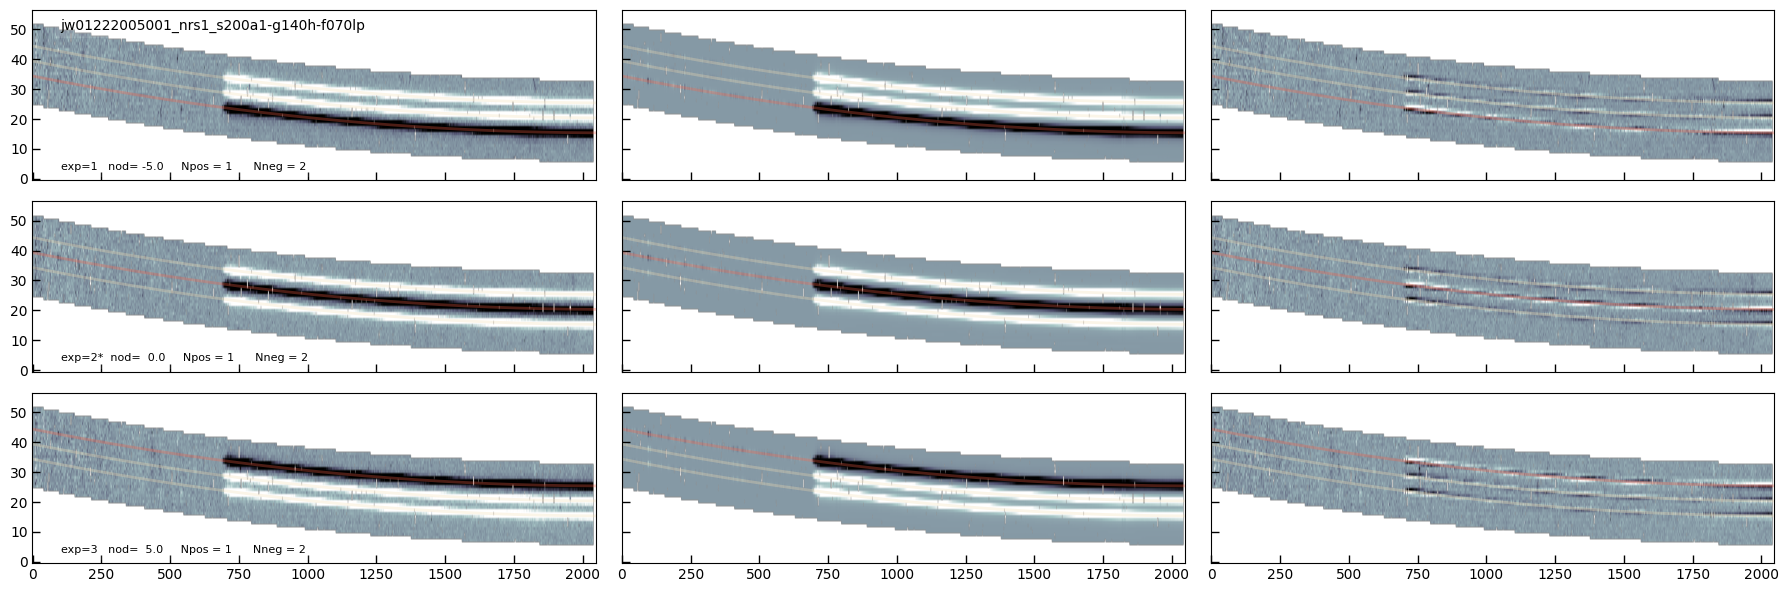

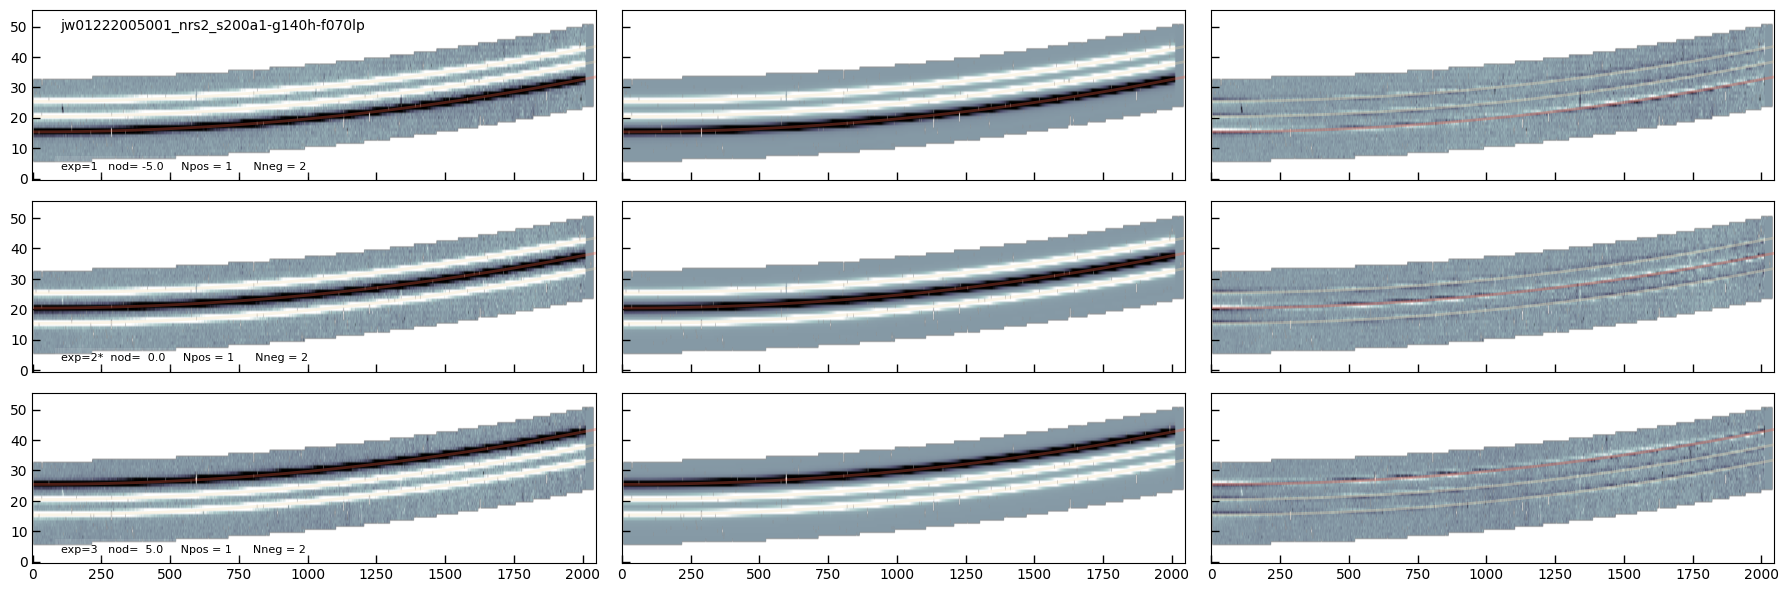

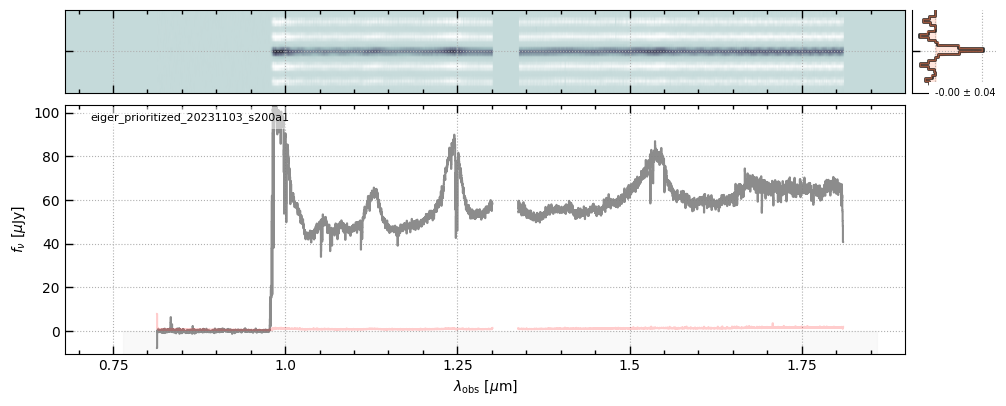

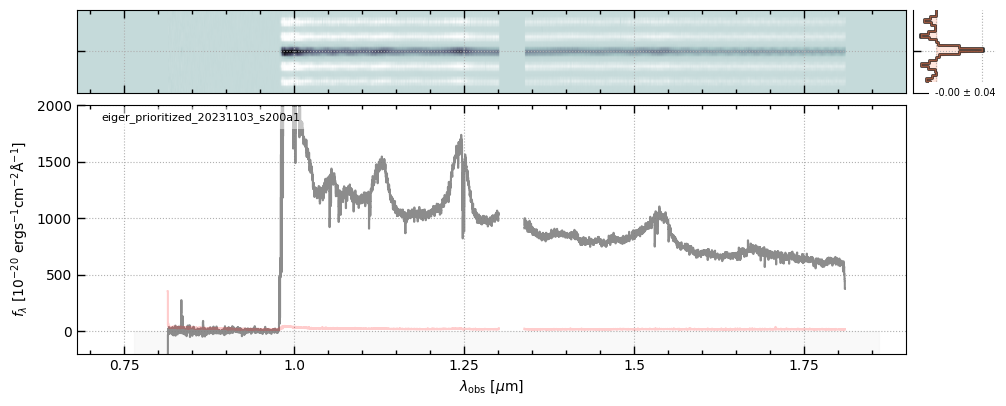

In [37]:
fs_obj, fs_info, fs_status = msaexp.cloud.handle_spectrum_extraction(
    sync=False,
    clean=False,
    skip_existing=False,
    files=fs_files,
    key=f"{prog}_{fixed_slit.lower()}",
    outroot=outroot,
    root=outroot,
    yaml_kwargs=yaml.dump(extra_kwargs),
    **kws,
)